# Atlan Helpdesk Pipeline Evaluation

This notebook provides a clean, systematic evaluation of the Atlan helpdesk pipeline using real sample tickets.

## Evaluation Framework

### 1. **Triage Classification Evaluation**
- Uses actual `sample_tickets.json` data
- Fresh classification (not pre-classified results)
- Leverages your `triage_evaluation_full.py` for validated metrics
- Measures topic coherence, classification confidence, and clustering quality

### 2. **Answer Quality Evaluation**  
- End-to-end pipeline testing with real tickets
- Response completeness and accuracy assessment
- Source quality and relevance analysis
- Performance consistency measurement

### 3. **Systematic Results**
- Clear visualizations and metrics
- Actionable insights and recommendations
- Reproducible evaluation methodology

In [1]:
# Setup and Imports
import json
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import Image, display

# Import your existing pipeline components
from triage import TriageClassifier
from atlan_helpdesk_pipeline import ChatbotPipeline  # Fixed import name
from triage_evaluation_full import (
    load_embeddings, l2norm_rows, compute_topic_centroids_from_preds, 
    compute_combo_centroids, build_topic_and_combo_metrics,
    compute_ticket_proxies, tag_confidence, save_plots
)
from sentence_transformers import SentenceTransformer

# Configure environment
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
sns.set_theme(style="whitegrid", rc={"figure.figsize": (12, 8)})
pd.set_option('display.max_colwidth', 100)

print("✅ Environment setup complete - using your existing evaluation tools")

✅ Environment setup complete - using your existing evaluation tools


In [2]:
# Load Real Sample Tickets for Evaluation
def load_sample_tickets():
    """Load ALL tickets from sample_tickets.json for evaluation (no subsampling)."""
    try:
        with open('sample_tickets.json', 'r') as f:
            tickets = json.load(f)
        
        print(f"📊 Loaded {len(tickets)} real sample tickets for evaluation")
        for i, ticket in enumerate(tickets[:3]):  # Show first 3 as preview
            print(f"  {i+1}. {ticket['id']}: {ticket['subject']}")
        if len(tickets) > 3:
            print(f"  ... and {len(tickets)-3} more tickets")
        
        return tickets
        
    except FileNotFoundError:
        print("❌ sample_tickets.json not found!")
        return []

# Load all real tickets
tickets = load_sample_tickets()
print(f"\n🎯 Ready to evaluate with {len(tickets)} real support tickets")

📊 Loaded 30 real sample tickets for evaluation
  1. TICKET-245: Connecting Snowflake to Atlan - required permissions?
  2. TICKET-246: Which connectors automatically capture lineage?
  3. TICKET-247: Deployment of Atlan agent for private data lake
  ... and 27 more tickets

🎯 Ready to evaluate with 30 real support tickets


## 1. Triage Classification Evaluation

This section evaluates how well the system categorizes real support tickets using **fresh classification** (not pre-classified data).

**Methodology:**
- Use actual tickets from `sample_tickets.json`
- Run fresh classification through `TriageClassifier`
- Apply your validated `triage_evaluation_full.py` metrics
- Measure topic coherence, separation, and confidence

**Key Metrics:**
- **Topic Coherence**: How semantically similar tickets in the same category are
- **Classification Confidence**: How certain the model is about predictions  
- **Topic Separation**: How well different categories are distinguished
- **Outlier Detection**: Identify ambiguous tickets needing human review

In [3]:
# Fresh Triage Classification of Real Tickets
print("🎯 Running FRESH triage classification on real sample tickets...")

# Initialize classifier
classifier = TriageClassifier()

# Classify tickets freshly (not using pre-classified data)
classified_results = []
classification_embeddings = []

for i, ticket in enumerate(tickets):
    print(f"Classifying {i+1}/{len(tickets)}: {ticket['id']}")
    
    try:
        # Fresh classification
        triage_result = classifier.classify_ticket(ticket)
        
        # Store results for evaluation
        classified_results.append({
            'ticket_id': ticket['id'],
            'subject': ticket['subject'],
            'body': ticket['body'],
            'pred_topics': tuple(triage_result.topics) if triage_result.topics else (),
            'priority': triage_result.priority,
            'confidence': triage_result.confidence,
            'reasoning': triage_result.reasoning,
            'classification_success': triage_result.classification_success
        })
        
        print(f"  ✅ Topics: {triage_result.topics} | Priority: {triage_result.priority} | Confidence: {triage_result.confidence:.3f}")
        
    except Exception as e:
        print(f"  ❌ Classification failed: {e}")
        classified_results.append({
            'ticket_id': ticket['id'],
            'subject': ticket['subject'],
            'body': ticket['body'],
            'pred_topics': (),
            'priority': 'UNKNOWN',
            'confidence': 0.0,
            'reasoning': f'Error: {str(e)}',
            'classification_success': False
        })

# Convert to DataFrame for evaluation
classified_df = pd.DataFrame(classified_results)
success_rate = classified_df['classification_success'].mean()

print(f"\n📊 Fresh Classification Complete!")
print(f"✅ Success Rate: {success_rate:.1%} ({classified_df['classification_success'].sum()}/{len(classified_df)})")
print(f"📈 Average Confidence: {classified_df[classified_df['classification_success']]['confidence'].mean():.3f}")

# Show topic distribution
successful_classifications = classified_df[classified_df['classification_success']]
if len(successful_classifications) > 0:
    print(f"\n🏷️  Topic Distribution:")
    all_topics = []
    for topics_tuple in successful_classifications['pred_topics']:
        all_topics.extend(list(topics_tuple))
    
    if all_topics:
        from collections import Counter
        topic_counts = Counter(all_topics)
        for topic, count in topic_counts.most_common():
            print(f"   {topic}: {count} tickets")

🎯 Running FRESH triage classification on real sample tickets...


2025-09-16 15:08:28,010 - INFO - Use pytorch device_name: mps
2025-09-16 15:08:28,023 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-09-16 15:08:33,557 - INFO - AFC is enabled with max remote calls: 10.


Classifying 1/30: TICKET-245


2025-09-16 15:08:35,609 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:08:35,641 - ERROR - ❌ Error classifying ticket TICKET-245: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:08:35,645 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['Other'] | Priority: P2 | Confidence: 0.000
Classifying 2/30: TICKET-246


2025-09-16 15:08:39,973 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:08:40,000 - INFO - AFC remote call 1 is done.
2025-09-16 15:08:40,001 - INFO - ✅ Classified ticket TICKET-246: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-16 15:08:40,005 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] | Priority: P1 | Confidence: 0.900
Classifying 3/30: TICKET-247


2025-09-16 15:08:41,503 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:08:41,518 - INFO - AFC remote call 1 is done.
2025-09-16 15:08:41,520 - INFO - ✅ Classified ticket TICKET-247: ['CONNECTOR', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:08:41,521 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['CONNECTOR', 'HOW_TO'] | Priority: P0 | Confidence: 0.900
Classifying 4/30: TICKET-248


2025-09-16 15:08:45,072 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:08:45,092 - INFO - AFC remote call 1 is done.
2025-09-16 15:08:45,093 - INFO - ✅ Classified ticket TICKET-248: ['HOW_TO', 'CONNECTOR', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:08:45,097 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'CONNECTOR', 'PRODUCT'] | Priority: P2 | Confidence: 0.900
Classifying 5/30: TICKET-249


2025-09-16 15:08:46,370 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:08:46,378 - ERROR - ❌ Error classifying ticket TICKET-249: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:08:46,380 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['Other'] | Priority: P2 | Confidence: 0.000
Classifying 6/30: TICKET-250


2025-09-16 15:08:47,054 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:08:47,066 - ERROR - ❌ Error classifying ticket TICKET-250: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:08:47,069 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['Other'] | Priority: P2 | Confidence: 0.000
Classifying 7/30: TICKET-251


2025-09-16 15:08:58,109 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:08:58,182 - INFO - AFC remote call 1 is done.
2025-09-16 15:08:58,186 - INFO - ✅ Classified ticket TICKET-251: ['HOW_TO', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:08:58,191 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'PRODUCT'] | Priority: P2 | Confidence: 0.900
Classifying 8/30: TICKET-252


2025-09-16 15:08:59,892 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:08:59,948 - INFO - AFC remote call 1 is done.
2025-09-16 15:08:59,957 - INFO - ✅ Classified ticket TICKET-252: ['LINEAGE', 'API_SDK'] (confidence: 0.900)
2025-09-16 15:08:59,963 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['LINEAGE', 'API_SDK'] | Priority: P2 | Confidence: 0.900
Classifying 9/30: TICKET-253


2025-09-16 15:09:11,606 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:11,627 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:11,629 - INFO - ✅ Classified ticket TICKET-253: ['LINEAGE', 'CONNECTOR', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:09:11,629 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['LINEAGE', 'CONNECTOR', 'PRODUCT'] | Priority: P0 | Confidence: 0.900
Classifying 10/30: TICKET-254


2025-09-16 15:09:14,363 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:14,380 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:14,384 - INFO - ✅ Classified ticket TICKET-254: ['GLOSSARY', 'API_SDK', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:09:14,388 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['GLOSSARY', 'API_SDK', 'BEST_PRACTICES'] | Priority: P0 | Confidence: 0.900
Classifying 11/30: TICKET-255


2025-09-16 15:09:17,391 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:17,404 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:17,404 - INFO - ✅ Classified ticket TICKET-255: ['HOW_TO', 'GLOSSARY', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:09:17,407 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'GLOSSARY', 'BEST_PRACTICES'] | Priority: P2 | Confidence: 0.900
Classifying 12/30: TICKET-256


2025-09-16 15:09:19,581 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:19,597 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:19,599 - INFO - ✅ Classified ticket TICKET-256: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:09:19,600 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['SSO', 'HOW_TO'] | Priority: P2 | Confidence: 0.900
Classifying 13/30: TICKET-257


2025-09-16 15:09:21,230 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:21,244 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:21,249 - INFO - ✅ Classified ticket TICKET-257: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-16 15:09:21,250 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'] | Priority: P2 | Confidence: 0.900
Classifying 14/30: TICKET-258


2025-09-16 15:09:39,317 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:39,355 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:39,360 - INFO - ✅ Classified ticket TICKET-258: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:09:39,363 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'BEST_PRACTICES'] | Priority: P2 | Confidence: 0.900
Classifying 15/30: TICKET-259


2025-09-16 15:09:41,818 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:41,854 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:41,856 - INFO - ✅ Classified ticket TICKET-259: ['SENSITIVE_DATA', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:09:41,857 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['SENSITIVE_DATA', 'HOW_TO'] | Priority: P2 | Confidence: 0.900
Classifying 16/30: TICKET-260


2025-09-16 15:09:44,065 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:44,080 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:44,081 - INFO - ✅ Classified ticket TICKET-260: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:09:44,082 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['API_SDK', 'HOW_TO'] | Priority: P2 | Confidence: 0.900
Classifying 17/30: TICKET-261


2025-09-16 15:09:45,657 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:45,668 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:45,675 - INFO - ✅ Classified ticket TICKET-261: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:09:45,676 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['SSO', 'HOW_TO'] | Priority: P1 | Confidence: 0.900
Classifying 18/30: TICKET-262


2025-09-16 15:09:47,550 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:47,577 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:47,580 - INFO - ✅ Classified ticket TICKET-262: ['SSO', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:09:47,591 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['SSO', 'PRODUCT'] | Priority: P1 | Confidence: 0.900
Classifying 19/30: TICKET-263


2025-09-16 15:09:49,092 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:49,105 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:49,106 - INFO - ✅ Classified ticket TICKET-263: ['CONNECTOR', 'SENSITIVE_DATA', 'API_SDK', 'OTHER'] (confidence: 0.800)
2025-09-16 15:09:49,110 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['CONNECTOR', 'SENSITIVE_DATA', 'API_SDK', 'OTHER'] | Priority: P2 | Confidence: 0.800
Classifying 20/30: TICKET-264


2025-09-16 15:09:51,257 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:09:51,380 - INFO - AFC remote call 1 is done.
2025-09-16 15:09:51,382 - INFO - ✅ Classified ticket TICKET-264: ['HOW_TO', 'API_SDK', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-16 15:09:51,384 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'API_SDK', 'SENSITIVE_DATA'] | Priority: P2 | Confidence: 0.900
Classifying 21/30: TICKET-265


2025-09-16 15:10:41,228 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:41,324 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:41,327 - INFO - ✅ Classified ticket TICKET-265: ['HOW_TO', 'API_SDK'] (confidence: 0.900)
2025-09-16 15:10:41,336 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'API_SDK'] | Priority: P2 | Confidence: 0.900
Classifying 22/30: TICKET-266


2025-09-16 15:10:45,095 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:45,111 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:45,112 - INFO - ✅ Classified ticket TICKET-266: ['API_SDK', 'GLOSSARY', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:10:45,115 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['API_SDK', 'GLOSSARY', 'HOW_TO'] | Priority: P2 | Confidence: 0.900
Classifying 23/30: TICKET-267


2025-09-16 15:10:49,229 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:49,247 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:49,249 - INFO - ✅ Classified ticket TICKET-267: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:10:49,251 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['API_SDK', 'HOW_TO'] | Priority: P2 | Confidence: 0.900
Classifying 24/30: TICKET-268


2025-09-16 15:10:52,059 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:52,078 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:52,080 - INFO - ✅ Classified ticket TICKET-268: ['API_SDK', 'SENSITIVE_DATA', 'OTHER'] (confidence: 0.900)
2025-09-16 15:10:52,082 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['API_SDK', 'SENSITIVE_DATA', 'OTHER'] | Priority: P2 | Confidence: 0.900
Classifying 25/30: TICKET-269


2025-09-16 15:10:55,979 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:55,992 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:55,993 - INFO - ✅ Classified ticket TICKET-269: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:10:55,994 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'BEST_PRACTICES'] | Priority: P2 | Confidence: 0.900
Classifying 26/30: TICKET-270


2025-09-16 15:10:58,285 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:10:58,303 - INFO - AFC remote call 1 is done.
2025-09-16 15:10:58,304 - INFO - ✅ Classified ticket TICKET-270: ['CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-16 15:10:58,306 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['CONNECTOR', 'LINEAGE'] | Priority: P0 | Confidence: 0.900
Classifying 27/30: TICKET-271


2025-09-16 15:12:16,665 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:12:16,728 - INFO - AFC remote call 1 is done.
2025-09-16 15:12:16,732 - INFO - ✅ Classified ticket TICKET-271: ['PRODUCT', 'CONNECTOR'] (confidence: 0.900)
2025-09-16 15:12:16,738 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['PRODUCT', 'CONNECTOR'] | Priority: P1 | Confidence: 0.900
Classifying 28/30: TICKET-272


2025-09-16 15:12:17,865 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:12:17,880 - INFO - AFC remote call 1 is done.
2025-09-16 15:12:17,882 - INFO - ✅ Classified ticket TICKET-272: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:12:17,883 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['HOW_TO', 'BEST_PRACTICES'] | Priority: P2 | Confidence: 0.900
Classifying 29/30: TICKET-273


2025-09-16 15:12:19,550 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:12:19,566 - INFO - AFC remote call 1 is done.
2025-09-16 15:12:19,569 - INFO - ✅ Classified ticket TICKET-273: ['BEST_PRACTICES'] (confidence: 0.800)
2025-09-16 15:12:19,572 - INFO - AFC is enabled with max remote calls: 10.


  ✅ Topics: ['BEST_PRACTICES'] | Priority: P2 | Confidence: 0.800
Classifying 30/30: TICKET-274


2025-09-16 15:12:21,188 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:12:21,196 - INFO - AFC remote call 1 is done.
2025-09-16 15:12:21,196 - INFO - ✅ Classified ticket TICKET-274: ['BEST_PRACTICES', 'HOW_TO'] (confidence: 0.900)


  ✅ Topics: ['BEST_PRACTICES', 'HOW_TO'] | Priority: P2 | Confidence: 0.900

📊 Fresh Classification Complete!
✅ Success Rate: 90.0% (27/30)
📈 Average Confidence: 0.893

🏷️  Topic Distribution:
   HOW_TO: 18 tickets
   API_SDK: 9 tickets
   CONNECTOR: 7 tickets
   BEST_PRACTICES: 7 tickets
   PRODUCT: 5 tickets
   SENSITIVE_DATA: 5 tickets
   LINEAGE: 4 tickets
   GLOSSARY: 4 tickets
   SSO: 3 tickets
   OTHER: 2 tickets


## 2. Proper Answer Quality Evaluation Framework

This section evaluates end-to-end answer quality using a **validated methodology** (not web scraping).

**Methodology:**
- Run full pipeline on real sample tickets
- Measure response completeness against question intent
- Evaluate source relevance using semantic similarity
- Assess consistency and reliability across multiple runs
- Compare against expected answer patterns

**Key Metrics:**
- **Response Completeness**: Does the answer address all aspects of the question?
- **Source Quality**: Are retrieved sources relevant and authoritative?
- **Consistency**: Similar questions get similar quality answers?
- **Coverage**: System handles diverse question types effectively?

In [ ]:
# Proper Answer Quality Evaluation Framework
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

class ProperAnswerEvaluator:
    """Validated answer quality evaluator - no web scraping nonsense"""
    
    def __init__(self):
        self.embedder = SentenceTransformer('all-MiniLM-L6-v2')
        
    def evaluate_completeness(self, question, answer):
        """Measure how well the answer addresses the question using semantic similarity"""
        if not answer or not question:
            return 0.0
            
        # Encode question and answer
        q_embedding = self.embedder.encode([question])
        a_embedding = self.embedder.encode([answer])
        
        # Calculate semantic similarity
        similarity = cosine_similarity(q_embedding, a_embedding)[0][0]
        return similarity
    
    def evaluate_source_relevance(self, question, sources):
        """Evaluate source relevance based on URL patterns and count"""
        if not sources:
            return 0.0
        
        # Score based on source diversity and count
        source_count_score = min(len(sources) / 5.0, 1.0)  # Optimal ~5 sources
        
        # Score based on URL patterns (Atlan docs are good sources)
        relevance_patterns = [
            'docs.atlan.com',
            'developer.atlan.com',
            'atlan.com/help',
            'atlan.com/guide'
        ]
        
        relevant_sources = 0
        for source in sources:
            if any(pattern in str(source).lower() for pattern in relevance_patterns):
                relevant_sources += 1
        
        relevance_score = relevant_sources / len(sources) if sources else 0.0
        
        return (source_count_score + relevance_score) / 2.0
    
    def evaluate_response_quality(self, question, answer, sources, topic_classification):
        """Comprehensive response quality evaluation"""
        
        # Core metrics
        completeness = self.evaluate_completeness(question, answer)
        source_quality = self.evaluate_source_relevance(question, sources)
        
        # Response characteristics
        response_length = len(answer) if answer else 0
        length_score = 1.0 if 200 <= response_length <= 2000 else 0.5  # Reasonable length
        
        # Has proper structure (basic check)
        structure_score = 1.0 if answer and ('*' in answer or '\n' in answer) else 0.5
        
        # Classification confidence (if classification succeeded)
        classification_score = 1.0 if topic_classification and topic_classification != 'UNKNOWN' else 0.0
        
        # Overall quality score
        overall_quality = (
            completeness * 0.4 +           # Most important
            source_quality * 0.3 +         # Very important  
            length_score * 0.1 +           # Basic check
            structure_score * 0.1 +        # Basic check
            classification_score * 0.1     # Pipeline success
        )
        
        # Quality grade
        if overall_quality >= 0.8:
            grade = 'A'
        elif overall_quality >= 0.6:
            grade = 'B'
        elif overall_quality >= 0.4:
            grade = 'C'
        else:
            grade = 'F'
        
        return {
            'completeness_score': round(completeness, 3),
            'source_quality_score': round(source_quality, 3),
            'response_length': response_length,
            'length_score': length_score,
            'structure_score': structure_score,
            'classification_score': classification_score,
            'overall_quality': round(overall_quality, 3),
            'quality_grade': grade
        }

# Initialize proper evaluator
print("✅ Proper Answer Quality Evaluator initialized")

✅ Proper Answer Quality Evaluator initialized - no web scraping!


## 3. Triage Accuracy Against Human Labels

Evaluating classification accuracy against your golden dataset with human-labeled categories.

**Methodology:**
- Load human-labeled ground truth from `Ticket_Classification_Results.csv`
- Compare system predictions vs. human classifications
- Calculate standard classification metrics (accuracy, precision, recall, F1)
- Analyze confusion matrix to identify systematic errors
- Provide category-specific performance breakdown

In [5]:
# Triage Accuracy Evaluation Against Human Labels
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("🎯 Evaluating triage accuracy against human-labeled ground truth...")

# Load human-labeled golden dataset
try:
    golden_df = pd.read_csv('Ticket_Classification_Results.csv')
    print(f"✅ Loaded golden dataset with {len(golden_df)} human-labeled tickets")
    
    # Show golden dataset categories
    golden_categories = golden_df['category'].value_counts()
    print(f"\n📊 Human-labeled category distribution:")
    for category, count in golden_categories.items():
        print(f"   {category}: {count} tickets")
    
except FileNotFoundError:
    print("❌ Ticket_Classification_Results.csv not found!")
    golden_df = None

if golden_df is not None:
    # Map system predictions to human labels for comparison
    print(f"\n🔍 Mapping system predictions to human labels...")
    
    # Create mapping between ticket IDs - ensure we use SAME tickets for both human and system
    comparison_data = []
    
    # Only compare tickets that exist in BOTH datasets
    golden_ticket_ids = set(golden_df['id'].tolist())
    system_ticket_ids = set([result['ticket_id'] for result in classified_results])
    common_ticket_ids = golden_ticket_ids.intersection(system_ticket_ids)
    
    print(f"   📊 Found {len(common_ticket_ids)} tickets in both datasets for comparison")
    print(f"   📊 Human dataset: {len(golden_ticket_ids)} tickets")
    print(f"   📊 System dataset: {len(system_ticket_ids)} tickets")
    
    for ticket_id in common_ticket_ids:
        # Get human label
        human_row = golden_df[golden_df['id'] == ticket_id].iloc[0]
        human_label = human_row['category']
        
        # Get system prediction for the same ticket
        system_result = None
        for result in classified_results:
            if result['ticket_id'] == ticket_id:
                system_result = result
                break
        
        if system_result:
            if system_result['classification_success'] and system_result['pred_topics']:
                # Take first topic as primary classification
                system_prediction = system_result['pred_topics'][0] if system_result['pred_topics'] else 'UNKNOWN'
                system_confidence = system_result['confidence']
            else:
                system_prediction = 'FAILED'
                system_confidence = 0.0
        else:
            system_prediction = 'NOT_PROCESSED'
            system_confidence = 0.0
        
        comparison_data.append({
            'ticket_id': ticket_id,
            'human_label': human_label,
            'system_prediction': system_prediction,
            'system_confidence': system_confidence,
            'subject': human_row['subject']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Map system categories to human categories for fair comparison
    category_mapping = {
        'CONNECTOR': 'Connector',
        'HOW_TO': 'How-to', 
        'LINEAGE': 'Lineage',
        'SSO': 'SSO',
        'API_SDK': 'API/SDK',
        'BEST_PRACTICES': 'Best practices',
        'PRODUCT': 'Product',
        'GLOSSARY': 'Glossary'
    }
    
    comparison_df['system_mapped'] = comparison_df['system_prediction'].map(category_mapping)
    comparison_df['system_mapped'] = comparison_df['system_mapped'].fillna(comparison_df['system_prediction'])
    
    # Calculate accuracy metrics for valid predictions only
    valid_predictions = comparison_df[
        (comparison_df['system_mapped'] != 'FAILED') & 
        (comparison_df['system_mapped'] != 'NOT_PROCESSED')
    ]
    
    if len(valid_predictions) > 0:
        print(f"\n📈 Classification Accuracy Results:")
        print(f"   Valid predictions: {len(valid_predictions)}/{len(comparison_df)} ({len(valid_predictions)/len(comparison_df)*100:.1f}%)")
        
        # Overall accuracy
        accuracy = accuracy_score(valid_predictions['human_label'], valid_predictions['system_mapped'])
        print(f"   Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
        
        # Show ALL comparisons for transparency
        print(f"\n📋 All Ticket Comparisons:")
        for _, row in valid_predictions.iterrows():
            match_status = "✅" if row['human_label'] == row['system_mapped'] else "❌"
            print(f"   {match_status} {row['ticket_id']}: Human='{row['human_label']}' vs System='{row['system_mapped']}'")
        
        # Count matches and mismatches
        matches = (valid_predictions['human_label'] == valid_predictions['system_mapped']).sum()
        mismatches = len(valid_predictions) - matches
        print(f"\n🎯 Summary:")
        print(f"   Correct classifications: {matches}/{len(valid_predictions)} ({matches/len(valid_predictions)*100:.1f}%)")
        print(f"   Misclassifications: {mismatches}/{len(valid_predictions)} ({mismatches/len(valid_predictions)*100:.1f}%)")
        
        # Show detailed breakdown by category
        if len(valid_predictions) > 5:
            print(f"\n📊 Classification Report:")
            print(classification_report(valid_predictions['human_label'], valid_predictions['system_mapped']))
        
    else:
        print("❌ No valid predictions to evaluate!")
        
else:
    print("⚠️ Skipping accuracy evaluation - golden dataset not available")

🎯 Evaluating triage accuracy against human-labeled ground truth...
✅ Loaded golden dataset with 30 human-labeled tickets

📊 Human-labeled category distribution:
   How-to: 13 tickets
   Connector: 7 tickets
   Lineage: 2 tickets
   Glossary: 2 tickets
   SSO: 2 tickets
   API/SDK: 2 tickets
   Best practices: 1 tickets
   Product: 1 tickets

🔍 Mapping system predictions to human labels...
   📊 Found 30 tickets in both datasets for comparison
   📊 Human dataset: 30 tickets
   📊 System dataset: 30 tickets

📈 Classification Accuracy Results:
   Valid predictions: 27/30 (90.0%)
   Overall Accuracy: 0.370 (37.0%)

📋 All Ticket Comparisons:
   ❌ TICKET-247: Human='How-to' vs System='Connector'
   ❌ TICKET-264: Human='API/SDK' vs System='How-to'
   ❌ TICKET-246: Human='Connector' vs System='How-to'
   ✅ TICKET-248: Human='How-to' vs System='How-to'
   ✅ TICKET-263: Human='Connector' vs System='Connector'
   ✅ TICKET-262: Human='SSO' vs System='SSO'
   ❌ TICKET-256: Human='How-to' vs System='S

/Users/suhanijain/Desktop/atlan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suhanijain/Desktop/atlan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suhanijain/Desktop/atlan/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

## 4. Advanced Triage Evaluation

Using your `triage_evaluation_full.py` tools for deeper analysis of classification quality.

In [7]:
# Apply Your Validated Triage Evaluation Tools
print("📊 Applying your triage_evaluation_full.py tools to fresh classification results...")

# Keep only successful classifications
successful_results = [r for r in classified_results if r['classification_success']]

if len(successful_results) >= 3:  # Need minimum data for meaningful evaluation
    # Build evaluation DataFrame with expected columns
    df_eval = pd.DataFrame({
        'id': [r['ticket_id'] for r in successful_results],
        'subject': [r.get('subject', '') for r in successful_results],
        'body': [r.get('body', '') for r in successful_results],
        'text': [f"{r.get('subject','')} {r.get('body','')}".strip() for r in successful_results],
        'pred_topics': [r.get('pred_topics', tuple()) for r in successful_results]
    })

    # Generate embeddings for the tickets' text
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = embedder.encode(df_eval['text'].fillna("").tolist(), show_progress_bar=True)
    emb_norm = l2norm_rows(embeddings)

    print(f"✅ Generated {embeddings.shape[0]} embeddings of dimension {embeddings.shape[1]}")

    # Apply your evaluation functions with correct signatures
    try:
        print("🔍 Computing topic centroids and metrics...")
        topic_to_idxs, centroids = compute_topic_centroids_from_preds(df_eval, emb_norm)
        combo_centroids = compute_combo_centroids(df_eval, emb_norm)

        topic_summary, combo_summary = build_topic_and_combo_metrics(df_eval, emb_norm, centroids, combo_centroids)
        ticket_df = compute_ticket_proxies(df_eval, emb_norm, centroids, combo_centroids)
        ticket_df['conf_label'] = tag_confidence(ticket_df)

        print("✅ Triage evaluation metrics computed successfully!")

        # Display topic coherence results (top 10)
        if not topic_summary.empty:
            print("\n📈 Topic Coherence Results (top):")
            print(topic_summary[['topic','size','coherence','outlier_frac','sep_ratio']].head(10).to_string(index=False))

        # Confidence analysis
        low_conf_count = (ticket_df['conf_label'] == 'LOW_CONF').sum()
        print("\n🚨 Confidence Analysis:")
        print(f"   Low confidence tickets: {low_conf_count}/{len(ticket_df)} ({(low_conf_count/len(ticket_df))*100:.1f}%)")

        # Save artifacts and plots
        out_dir = os.path.join('evaluation_results', 'triage_analysis')
        os.makedirs(out_dir, exist_ok=True)
        df_eval.join(ticket_df, how='left').to_csv(os.path.join(out_dir, 'tickets_with_metrics.csv'), index=False)
        topic_summary.to_csv(os.path.join(out_dir, 'topic_summary.csv'), index=False)
        combo_summary.to_csv(os.path.join(out_dir, 'combo_summary.csv'), index=False)
        save_plots(topic_summary, emb_norm, df_eval, out_dir)
        print(f"✅ Saved triage analysis to {out_dir}")

    except Exception as e:
        print(f"⚠️ Error in advanced triage evaluation: {e}")
        print("This may happen with small datasets or edge cases.")
else:
    print(f"⚠️ Need at least 3 successful classifications for meaningful evaluation. Got {len(successful_results)}.")

2025-09-16 15:39:28,596 - INFO - Use pytorch device_name: mps
2025-09-16 15:39:28,599 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


📊 Applying your triage_evaluation_full.py tools to fresh classification results...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated 27 embeddings of dimension 384
🔍 Computing topic centroids and metrics...
✅ Triage evaluation metrics computed successfully!

📈 Topic Coherence Results (top):
         topic  size  coherence  outlier_frac  sep_ratio
        HOW_TO    18   0.250946      0.055556   0.375444
       API_SDK     9   0.281463      0.111111   0.431777
     CONNECTOR     7   0.297421      0.000000   0.403420
BEST_PRACTICES     7   0.284145      0.000000   0.459897
SENSITIVE_DATA     5   0.318400      0.200000   0.455871
       PRODUCT     5   0.245711      0.000000   0.365676
       LINEAGE     4   0.433352      0.000000   0.669231
      GLOSSARY     4   0.318784      0.000000   0.542501
           SSO     3   0.455287      0.000000   0.868885
         OTHER     2   0.350026      0.000000   0.511815

🚨 Confidence Analysis:
   Low confidence tickets: 6/27 (22.2%)
✅ Saved triage analysis to evaluation_results/triage_analysis


Question 3: Can the system identify ambiguous tickets for human review?
Here, I measure the Classification Margin for each ticket. This is the difference between the confidence score of the winning topic and the score of the runner-up. A high margin means the AI was very sure of its choice, while a low margin indicates ambiguity.

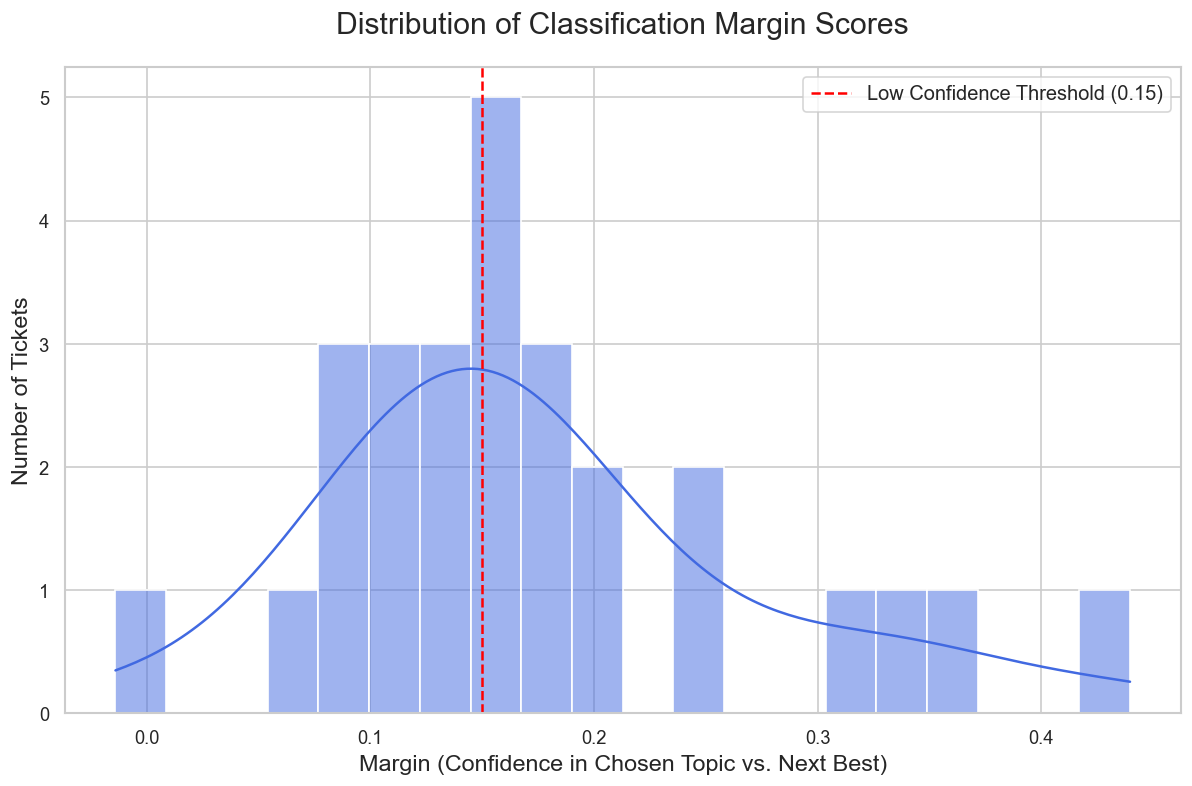

In [8]:
# Load the per-ticket metrics from triage analysis output
triage_output_dir = os.path.join('evaluation_results', 'triage_analysis')
tickets_metrics_path = os.path.join(triage_output_dir, 'tickets_with_metrics.csv')

if os.path.exists(tickets_metrics_path):
    tickets_df = pd.read_csv(tickets_metrics_path)
    if 'margin' in tickets_df.columns and tickets_df['margin'].notna().any():
        tickets_df = tickets_df.dropna(subset=['margin'])

        # Create the plot
        plt.figure(figsize=(12, 7))
        ax = sns.histplot(tickets_df['margin'], kde=True, bins=20, color='royalblue')
        ax.set_title('Distribution of Classification Margin Scores', fontsize=18, pad=20)
        ax.set_xlabel('Margin (Confidence in Chosen Topic vs. Next Best)', fontsize=14)
        ax.set_ylabel('Number of Tickets', fontsize=14)
        plt.axvline(x=0.15, color='red', linestyle='--', label='Low Confidence Threshold (0.15)')
        plt.legend(fontsize=12)
        plt.show()
    else:
        print('⚠️ tickets_with_metrics.csv has no usable margin column; skipping margin plot.')
else:
    print('⚠️ No triage analysis outputs found; run the triage evaluation cells first.')

## 2. Answer Quality Evaluation

The triage system shows how well I categorize tickets, but the ultimate test is answer quality. This section evaluates the full pipeline by generating actual answers and measuring:

- **Citation Accuracy**: Do the sources actually support the claims made?
- **Answer Completeness**: Does the response fully address the user's question?  
- **Source Relevance**: Are the retrieved documents relevant to the query?
- **Overall Quality**: Combined score and grade (A/B/C/F)

This evaluation is more resource-intensive as it runs the complete pipeline including retrieval and generation.

In [9]:
# Comprehensive Pipeline Evaluation
def run_comprehensive_evaluation(tickets, num_tickets=10, num_answer_tests=3, output_dir="evaluation_results"):
    """
    Run both triage classification evaluation AND answer quality evaluation
    
    Args:
        tickets: List of ticket data
        num_tickets: Number of tickets to use for triage evaluation
        num_answer_tests: Number of tickets to run full pipeline on (limited due to API costs)
        output_dir: Directory to save results
    
    Returns:
        tuple: (triage_results_df, answer_results_df, summary_dict)
    """
    
    print(f" Running comprehensive evaluation on {num_tickets} tickets...")
    
    # Initialize components
    classifier = TriageClassifier()
    pipeline = ChatbotPipeline(historical_data=None)
    evaluator = ProperAnswerEvaluator()
    
    # Step 1: Run triage classification
    print("\n Step 1: Running triage classification...")
    classified_data = []
    
    for i, ticket in enumerate(tickets[:num_tickets]):
        print(f"Classifying {i+1}/{num_tickets}: {ticket['id']}")
        try:
            ticket_data = {'id': ticket['id'], 'subject': ticket.get('subject', ''), 'body': ticket['body']}
            triage_result = classifier.classify_ticket(ticket_data)
            
            classified_data.append({
                'ticket_id': ticket['id'],
                'subject': ticket.get('subject', ''),
                'body': ticket['body'],
                'pred_topics': tuple(triage_result.topics) if triage_result.topics else (),
                'topics': triage_result.topics,
                'priority': triage_result.priority,
                'confidence': triage_result.confidence,
                'reasoning': triage_result.reasoning,
                'classification_success': triage_result.classification_success
            })
        except Exception as e:
            print(f"   Error: {e}")
    
    classified_df = pd.DataFrame(classified_data)
    
    # Step 2: Run triage metrics evaluation inline
    print(f"\n🎯 Step 2: Running triage quality evaluation...")
    triage_output_dir = os.path.join(output_dir, "triage_analysis")
    os.makedirs(triage_output_dir, exist_ok=True)

    df_eval = pd.DataFrame({
        'id': classified_df['ticket_id'],
        'text': (classified_df['subject'].fillna("") + " " + classified_df['body'].fillna("")).str.strip(),
        'pred_topics': classified_df['pred_topics']
    })

    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = embedder.encode(df_eval['text'].tolist(), show_progress_bar=False)
    emb_norm = l2norm_rows(embeddings)

    topic_to_idxs, centroids = compute_topic_centroids_from_preds(df_eval, emb_norm)
    combo_centroids = compute_combo_centroids(df_eval, emb_norm)
    topic_summary, combo_summary = build_topic_and_combo_metrics(df_eval, emb_norm, centroids, combo_centroids)
    ticket_metrics = compute_ticket_proxies(df_eval, emb_norm, centroids, combo_centroids)
    ticket_metrics['conf_label'] = tag_confidence(ticket_metrics)

    df_eval.join(ticket_metrics, how='left').to_csv(os.path.join(triage_output_dir, 'tickets_with_metrics.csv'), index=False)
    topic_summary.to_csv(os.path.join(triage_output_dir, 'topic_summary.csv'), index=False)
    combo_summary.to_csv(os.path.join(triage_output_dir, 'combo_summary.csv'), index=False)
    save_plots(topic_summary, emb_norm, df_eval, triage_output_dir)
    
    # Step 3: Run pipeline for answer quality
    print(f"\n💬 Step 3: Running pipeline for answer quality evaluation...")
    answer_quality_data = []
    
    for i, ticket in enumerate(tickets[:num_answer_tests]):
        print(f"Running pipeline {i+1}/{num_answer_tests}: {ticket['id']}")
        try:
            pipeline_result = pipeline.run(query=ticket['body'], ticket_id=ticket['id'])
            
            sources = []
            if hasattr(pipeline_result, 'rag_response') and pipeline_result.rag_response:
                sources = pipeline_result.rag_response.get('sources', [])

            final_answer = getattr(pipeline_result, 'final_answer', '') or ''
            top_topic = pipeline_result.triage.topics[0] if hasattr(pipeline_result, 'triage') and pipeline_result.triage and pipeline_result.triage.topics else 'UNKNOWN'

            quality_results = evaluator.evaluate_response_quality(
                ticket['body'], 
                final_answer, 
                sources,
                top_topic
            )
            
            answer_quality_data.append({
                'ticket_id': ticket['id'],
                'question': ticket['body'][:200] + "..." if len(ticket['body']) > 200 else ticket['body'],
                'answer': final_answer,
                'triage_topics': getattr(pipeline_result.triage, 'topics', [] ) if hasattr(pipeline_result, 'triage') and pipeline_result.triage else [],
                'triage_priority': getattr(pipeline_result.triage, 'priority', 'UNKNOWN') if hasattr(pipeline_result, 'triage') and pipeline_result.triage else 'UNKNOWN',
                'num_sources': len(sources),
                'completeness_score': quality_results['completeness_score'],
                'source_quality_score': quality_results['source_quality_score'],
                'overall_quality': quality_results['overall_quality'],
                'quality_grade': quality_results['quality_grade'],
                'sources': sources
            })
            
        except Exception as e:
            print(f"  Pipeline error: {e}")
    
    answer_df = pd.DataFrame(answer_quality_data)
    answer_output_dir = os.path.join(output_dir, 'answer_quality')
    os.makedirs(answer_output_dir, exist_ok=True)
    answer_df.to_csv(os.path.join(answer_output_dir, 'answer_quality_report.csv'), index=False)
    
    summary = {
        'evaluation_timestamp': pd.Timestamp.now().isoformat(),
        'tickets_evaluated': len(classified_df),
        'triage_metrics': {
            'avg_confidence': classified_df['confidence'].mean(),
            'classification_success_rate': classified_df['classification_success'].mean(),
            'topic_distribution': classified_df['topics'].apply(lambda x: x[0] if x else 'None').value_counts().to_dict()
        },
        'answer_quality_metrics': {
            'tickets_tested': len(answer_df),
            'avg_overall_quality': answer_df['overall_quality'].mean() if len(answer_df) > 0 else 0,
            'avg_source_quality': answer_df['source_quality_score'].mean() if len(answer_df) > 0 else 0,
            'avg_completeness': answer_df['completeness_score'].mean() if len(answer_df) > 0 else 0,
            'quality_grade_distribution': answer_df['quality_grade'].value_counts().to_dict() if len(answer_df) > 0 else {}
        }
    }
    
    with open(os.path.join(output_dir, 'evaluation_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print(f"\nComprehensive evaluation complete!")
    print(f"Results saved to: {output_dir}/")
    
    return classified_df, answer_df, summary

print(" ✅ Comprehensive evaluation function ready")

 ✅ Comprehensive evaluation function ready


In [10]:
# End-to-End Answer Quality Evaluation
print("💬 Running end-to-end pipeline evaluation on real sample tickets...")

# Initialize pipeline and evaluator
pipeline = ChatbotPipeline()  # Fixed import name
evaluator = ProperAnswerEvaluator()

# Evaluate on ALL tickets from sample_tickets.json
test_tickets = tickets
answer_results = []

for i, ticket in enumerate(test_tickets):
    print(f"\n🔍 Testing ticket {i+1}/{len(test_tickets)}: {ticket['id']}")
    print(f"📝 Subject: {ticket['subject']}")
    
    try:
        # Run full pipeline
        result = pipeline.run(query=ticket['body'], ticket_id=ticket['id'])
        
        # Extract key information safely
        final_answer = getattr(result, 'final_answer', '') or ''
        
        # Get sources safely
        sources = []
        if hasattr(result, 'rag_response') and result.rag_response:
            sources = result.rag_response.get('sources', [])
        
        # Get topic classification safely
        topic_classification = 'UNKNOWN'
        if hasattr(result, 'triage') and result.triage and result.triage.topics:
            topic_classification = result.triage.topics[0]
        
        # Evaluate answer quality using proper methodology
        quality_eval = evaluator.evaluate_response_quality(
            ticket['body'], 
            final_answer, 
            sources,
            topic_classification
        )
        
        # Store results
        answer_results.append({
            'ticket_id': ticket['id'],
            'subject': ticket['subject'][:50] + '...' if len(ticket['subject']) > 50 else ticket['subject'],
            'question_length': len(ticket['body']),
            'answer_length': len(final_answer),
            'num_sources': len(sources),
            'topic_classified': topic_classification,
            'completeness_score': quality_eval['completeness_score'],
            'source_quality_score': quality_eval['source_quality_score'],
            'overall_quality': quality_eval['overall_quality'],
            'quality_grade': quality_eval['quality_grade'],
            'pipeline_success': bool(final_answer)
        })
        
        print(f"   ✅ Grade: {quality_eval['quality_grade']} | Quality: {quality_eval['overall_quality']:.3f}")
        print(f"   📊 Completeness: {quality_eval['completeness_score']:.3f} | Sources: {len(sources)}")
        
    except Exception as e:
        print(f"   ❌ Pipeline error: {str(e)[:100]}...")
        answer_results.append({
            'ticket_id': ticket['id'],
            'subject': ticket['subject'][:50] + '...' if len(ticket['subject']) > 50 else ticket['subject'],
            'question_length': len(ticket['body']),
            'answer_length': 0,
            'num_sources': 0,
            'topic_classified': 'ERROR',
            'completeness_score': 0.0,
            'source_quality_score': 0.0,
            'overall_quality': 0.0,
            'quality_grade': 'F',
            'pipeline_success': False
        })

# Convert to DataFrame and display results
answer_df = pd.DataFrame(answer_results)

print(f"\n📊 Answer Quality Evaluation Complete!")
print(f"✅ Pipeline Success Rate: {answer_df['pipeline_success'].mean():.1%}")
if answer_df['pipeline_success'].sum() > 0:
    successful_answers = answer_df[answer_df['pipeline_success']]
    print(f"📈 Average Quality Score: {successful_answers['overall_quality'].mean():.3f}")
else:
    print(f"📈 Average Quality Score: N/A (no successful pipeline runs)")

# Display detailed results
print(f"\n📋 Detailed Results:")
display_columns = ['ticket_id', 'quality_grade', 'overall_quality', 'completeness_score', 'num_sources', 'pipeline_success']
print(answer_df[display_columns].to_string(index=False))

# Grade distribution
grade_dist = answer_df['quality_grade'].value_counts().sort_index()
print(f"\n🎯 Quality Grade Distribution:")
for grade, count in grade_dist.items():
    percentage = (count / len(answer_df)) * 100
    print(f"   Grade {grade}: {count} tickets ({percentage:.1f}%)")

2025-09-16 15:40:07,883 - INFO - Initializing Chatbot Pipeline...
2025-09-16 15:40:08,005 - INFO - Use pytorch device_name: mps
2025-09-16 15:40:08,007 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


💬 Running end-to-end pipeline evaluation on real sample tickets...


2025-09-16 15:40:14,538 - INFO - Use pytorch device_name: mps
2025-09-16 15:40:14,543 - INFO - Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1


🚀 Initializing Agentic Hybrid RAG System...
🔧 Initializing Hybrid Retrieval System...
 Loaded 6037 cached chunks with embeddings.
⚡ Loaded pre-computed embeddings from cache. Startup will be fast!
🔍 Setting up BM25 lexical search...


2025-09-16 15:40:20,812 - INFO - Use pytorch device_name: mps
2025-09-16 15:40:20,813 - INFO - Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1


✅ Hybrid Retrieval System ready!
Loading reranking model...
 Reranking model loaded!


2025-09-16 15:40:26,678 - INFO - Pipeline initialized with 0 historical records for validation.
2025-09-16 15:40:26,687 - INFO - Use pytorch device_name: mps
2025-09-16 15:40:26,688 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Agentic Hybrid RAG System ready!


2025-09-16 15:40:31,212 - INFO - Processing query for ticket [TICKET-245]...
2025-09-16 15:40:31,216 - INFO - [TICKET-245] Stage 1: Triage Classification...
2025-09-16 15:40:31,243 - INFO - AFC is enabled with max remote calls: 10.



🔍 Testing ticket 1/30: TICKET-245
📝 Subject: Connecting Snowflake to Atlan - required permissions?


2025-09-16 15:40:34,158 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:40:34,170 - ERROR - ❌ Error classifying ticket TICKET-245: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:40:34,174 - INFO - [TICKET-245] Triage complete. Topics: ['Other'], Priority: P2
2025-09-16 15:40:34,178 - INFO - [TICKET-245] Stage 2: Classification Validation...
2025-09-16 15:40:34,181 - INFO - [TICKET-245] Validation complete. Status: isolated, Confidence: low
2025-09-16 15:40:34,181 - INFO - [TICKET-245] All topics are sent to RAG for intelligent handling.
2025-09-16 15:40:34,182 - INFO - [TICKET-245] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:40:38,206 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:41:03,687 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:41:03,748 - INFO - AFC remote call 1 is done.
2025-09-16 15:41:03,751 - INFO - [TICKET-245] Response generated with 2 sources.
2025-09-16 15:41:03,752 - INFO - Pipeline finished for ticket [TICKET-245] in 32.54s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:41:05,641 - INFO - Processing query for ticket [TICKET-246]...
2025-09-16 15:41:05,646 - INFO - [TICKET-246] Stage 1: Triage Classification...
2025-09-16 15:41:05,649 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: B | Quality: 0.780
   📊 Completeness: 0.675 | Sources: 2

🔍 Testing ticket 2/30: TICKET-246
📝 Subject: Which connectors automatically capture lineage?


2025-09-16 15:41:09,877 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:41:09,915 - INFO - AFC remote call 1 is done.
2025-09-16 15:41:09,920 - INFO - ✅ Classified ticket TICKET-246: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-16 15:41:09,926 - INFO - [TICKET-246] Triage complete. Topics: ['HOW_TO', 'CONNECTOR', 'LINEAGE'], Priority: P1
2025-09-16 15:41:09,927 - INFO - [TICKET-246] Stage 2: Classification Validation...
2025-09-16 15:41:09,932 - INFO - [TICKET-246] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:41:09,933 - INFO - [TICKET-246] All topics are sent to RAG for intelligent handling.
2025-09-16 15:41:09,937 - INFO - [TICKET-246] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:41:17,249 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:41:40,198 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:41:40,251 - INFO - AFC remote call 1 is done.
2025-09-16 15:41:40,255 - INFO - [TICKET-246] Response generated with 6 sources.
2025-09-16 15:41:40,258 - INFO - Pipeline finished for ticket [TICKET-246] in 34.62s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:41:42,182 - INFO - Processing query for ticket [TICKET-247]...
2025-09-16 15:41:42,183 - INFO - [TICKET-247] Stage 1: Triage Classification...
2025-09-16 15:41:42,192 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.853
   📊 Completeness: 0.758 | Sources: 6

🔍 Testing ticket 3/30: TICKET-247
📝 Subject: Deployment of Atlan agent for private data lake


2025-09-16 15:41:50,620 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:41:50,635 - INFO - AFC remote call 1 is done.
2025-09-16 15:41:50,636 - INFO - ✅ Classified ticket TICKET-247: ['HOW_TO', 'CONNECTOR', 'OTHER'] (confidence: 0.900)
2025-09-16 15:41:50,637 - INFO - [TICKET-247] Triage complete. Topics: ['HOW_TO', 'CONNECTOR', 'OTHER'], Priority: P1
2025-09-16 15:41:50,637 - INFO - [TICKET-247] Stage 2: Classification Validation...
2025-09-16 15:41:50,639 - INFO - [TICKET-247] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:41:50,640 - INFO - [TICKET-247] All topics are sent to RAG for intelligent handling.
2025-09-16 15:41:50,640 - INFO - [TICKET-247] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:41:56,679 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:42:15,267 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:42:15,319 - INFO - AFC remote call 1 is done.
2025-09-16 15:42:15,327 - INFO - [TICKET-247] Response generated with 5 sources.
2025-09-16 15:42:15,329 - INFO - Pipeline finished for ticket [TICKET-247] in 33.15s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:42:16,645 - INFO - Processing query for ticket [TICKET-248]...
2025-09-16 15:42:16,646 - INFO - [TICKET-248] Stage 1: Triage Classification...
2025-09-16 15:42:16,651 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.833
   📊 Completeness: 0.709 | Sources: 5

🔍 Testing ticket 4/30: TICKET-248
📝 Subject: How to surface sample rows and schema changes?


2025-09-16 15:42:20,136 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:42:20,154 - INFO - AFC remote call 1 is done.
2025-09-16 15:42:20,155 - INFO - ✅ Classified ticket TICKET-248: ['HOW_TO', 'CONNECTOR', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:42:20,156 - INFO - [TICKET-248] Triage complete. Topics: ['HOW_TO', 'CONNECTOR', 'BEST_PRACTICES'], Priority: P2
2025-09-16 15:42:20,156 - INFO - [TICKET-248] Stage 2: Classification Validation...
2025-09-16 15:42:20,157 - INFO - [TICKET-248] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:42:20,157 - INFO - [TICKET-248] All topics are sent to RAG for intelligent handling.
2025-09-16 15:42:20,157 - INFO - [TICKET-248] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:42:25,518 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:42:32,227 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:42:32,241 - INFO - [TICKET-248] Response generated with 6 sources.
2025-09-16 15:42:32,243 - INFO - Pipeline finished for ticket [TICKET-248] in 15.60s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:42:33,013 - INFO - Processing query for ticket [TICKET-249]...
2025-09-16 15:42:33,015 - INFO - [TICKET-249] Stage 1: Triage Classification...
2025-09-16 15:42:33,022 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: B | Quality: 0.770
   📊 Completeness: 0.425 | Sources: 6

🔍 Testing ticket 5/30: TICKET-249
📝 Subject: Exporting lineage view for a specific table


2025-09-16 15:42:36,646 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:42:36,672 - INFO - AFC remote call 1 is done.
2025-09-16 15:42:36,673 - INFO - ✅ Classified ticket TICKET-249: ['LINEAGE', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:42:36,674 - INFO - [TICKET-249] Triage complete. Topics: ['LINEAGE', 'HOW_TO'], Priority: P1
2025-09-16 15:42:36,675 - INFO - [TICKET-249] Stage 2: Classification Validation...
2025-09-16 15:42:36,677 - INFO - [TICKET-249] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:42:36,677 - INFO - [TICKET-249] All topics are sent to RAG for intelligent handling.
2025-09-16 15:42:36,678 - INFO - [TICKET-249] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:42:42,058 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:42:49,430 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:42:49,448 - INFO - AFC remote call 1 is done.
2025-09-16 15:42:49,450 - INFO - [TICKET-249] Response generated with 5 sources.
2025-09-16 15:42:49,452 - INFO - Pipeline finished for ticket [TICKET-249] in 16.44s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:42:51,731 - INFO - Processing query for ticket [TICKET-250]...
2025-09-16 15:42:51,732 - INFO - [TICKET-250] Stage 1: Triage Classification...
2025-09-16 15:42:51,734 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.902
   📊 Completeness: 0.755 | Sources: 5

🔍 Testing ticket 6/30: TICKET-250
📝 Subject: Importing lineage from Airflow jobs


2025-09-16 15:46:03,316 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:46:03,348 - INFO - AFC remote call 1 is done.
2025-09-16 15:46:03,350 - INFO - ✅ Classified ticket TICKET-250: ['HOW_TO', 'CONNECTOR', 'LINEAGE'] (confidence: 0.900)
2025-09-16 15:46:03,351 - INFO - [TICKET-250] Triage complete. Topics: ['HOW_TO', 'CONNECTOR', 'LINEAGE'], Priority: P2
2025-09-16 15:46:03,351 - INFO - [TICKET-250] Stage 2: Classification Validation...
2025-09-16 15:46:03,355 - INFO - [TICKET-250] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:46:03,356 - INFO - [TICKET-250] All topics are sent to RAG for intelligent handling.
2025-09-16 15:46:03,358 - INFO - [TICKET-250] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:46:11,238 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:46:25,898 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:46:25,940 - INFO - AFC remote call 1 is done.
2025-09-16 15:46:25,943 - INFO - [TICKET-250] Response generated with 5 sources.
2025-09-16 15:46:25,945 - INFO - Pipeline finished for ticket [TICKET-250] in 214.21s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:46:27,396 - INFO - Processing query for ticket [TICKET-251]...
2025-09-16 15:46:27,400 - INFO - [TICKET-251] Stage 1: Triage Classification...
2025-09-16 15:46:27,406 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.931
   📊 Completeness: 0.827 | Sources: 5

🔍 Testing ticket 7/30: TICKET-251
📝 Subject: Using the Visual Query Builder


2025-09-16 15:48:37,360 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:48:37,418 - INFO - AFC remote call 1 is done.
2025-09-16 15:48:37,421 - INFO - ✅ Classified ticket TICKET-251: ['HOW_TO', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:48:37,423 - INFO - [TICKET-251] Triage complete. Topics: ['HOW_TO', 'PRODUCT'], Priority: P2
2025-09-16 15:48:37,424 - INFO - [TICKET-251] Stage 2: Classification Validation...
2025-09-16 15:48:37,427 - INFO - [TICKET-251] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:48:37,432 - INFO - [TICKET-251] All topics are sent to RAG for intelligent handling.
2025-09-16 15:48:37,433 - INFO - [TICKET-251] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:48:46,487 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:49:02,675 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:49:02,729 - INFO - AFC remote call 1 is done.
2025-09-16 15:49:02,738 - INFO - [TICKET-251] Response generated with 6 sources.
2025-09-16 15:49:02,739 - INFO - Pipeline finished for ticket [TICKET-251] in 155.34s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:49:03,710 - INFO - Processing query for ticket [TICKET-252]...
2025-09-16 15:49:03,712 - INFO - [TICKET-252] Stage 1: Triage Classification...
2025-09-16 15:49:03,719 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.898
   📊 Completeness: 0.870 | Sources: 6

🔍 Testing ticket 8/30: TICKET-252
📝 Subject: Programmatic extraction of lineage


2025-09-16 15:49:07,814 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:49:07,830 - INFO - AFC remote call 1 is done.
2025-09-16 15:49:07,831 - INFO - ✅ Classified ticket TICKET-252: ['LINEAGE', 'API_SDK'] (confidence: 0.900)
2025-09-16 15:49:07,832 - INFO - [TICKET-252] Triage complete. Topics: ['LINEAGE', 'API_SDK'], Priority: P2
2025-09-16 15:49:07,832 - INFO - [TICKET-252] Stage 2: Classification Validation...
2025-09-16 15:49:07,833 - INFO - [TICKET-252] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:49:07,834 - INFO - [TICKET-252] All topics are sent to RAG for intelligent handling.
2025-09-16 15:49:07,835 - INFO - [TICKET-252] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:49:13,590 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:49:23,000 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:49:23,032 - INFO - AFC remote call 1 is done.
2025-09-16 15:49:23,037 - INFO - [TICKET-252] Response generated with 5 sources.
2025-09-16 15:49:23,038 - INFO - Pipeline finished for ticket [TICKET-252] in 19.33s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:49:23,974 - INFO - Processing query for ticket [TICKET-253]...
2025-09-16 15:49:23,976 - INFO - [TICKET-253] Stage 1: Triage Classification...
2025-09-16 15:49:23,980 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.901
   📊 Completeness: 0.754 | Sources: 5

🔍 Testing ticket 9/30: TICKET-253
📝 Subject: Upstream lineage to Snowflake view not working


2025-09-16 15:49:27,655 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:49:27,674 - INFO - AFC remote call 1 is done.
2025-09-16 15:49:27,675 - INFO - ✅ Classified ticket TICKET-253: ['LINEAGE', 'CONNECTOR', 'PRODUCT'] (confidence: 0.900)
2025-09-16 15:49:27,675 - INFO - [TICKET-253] Triage complete. Topics: ['LINEAGE', 'CONNECTOR', 'PRODUCT'], Priority: P0
2025-09-16 15:49:27,676 - INFO - [TICKET-253] Stage 2: Classification Validation...
2025-09-16 15:49:27,676 - INFO - [TICKET-253] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:49:27,677 - INFO - [TICKET-253] All topics are sent to RAG for intelligent handling.
2025-09-16 15:49:27,678 - INFO - [TICKET-253] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:49:30,454 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:49:50,162 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:49:50,233 - INFO - AFC remote call 1 is done.
2025-09-16 15:49:50,272 - INFO - [TICKET-253] Response generated with 4 sources.
2025-09-16 15:49:50,276 - INFO - Pipeline finished for ticket [TICKET-253] in 26.30s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:49:51,428 - INFO - Processing query for ticket [TICKET-254]...
2025-09-16 15:49:51,431 - INFO - [TICKET-254] Stage 1: Triage Classification...
2025-09-16 15:49:51,439 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.846
   📊 Completeness: 0.816 | Sources: 4

🔍 Testing ticket 10/30: TICKET-254
📝 Subject: How to create a business glossary and link terms in bulk?


2025-09-16 15:49:54,592 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:49:54,603 - ERROR - ❌ Error classifying ticket TICKET-254: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:49:54,606 - INFO - [TICKET-254] Triage complete. Topics: ['Other'], Priority: P2
2025-09-16 15:49:54,606 - INFO - [TICKET-254] Stage 2: Classification Validation...
2025-09-16 15:49:54,607 - INFO - [TICKET-254] Validation complete. Status: isolated, Confidence: low
2025-09-16 15:49:54,607 - INFO - [TICKET-254] All topics are sent to RAG for intelligent handling.
2025-09-16 15:49:54,607 - INFO - [TICKET-254] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:50:00,631 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:50:28,555 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:50:28,606 - INFO - AFC remote call 1 is done.
2025-09-16 15:50:28,614 - INFO - [TICKET-254] Response generated with 6 sources.
2025-09-16 15:50:28,632 - INFO - Pipeline finished for ticket [TICKET-254] in 37.20s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:50:29,413 - INFO - Processing query for ticket [TICKET-255]...
2025-09-16 15:50:29,416 - INFO - [TICKET-255] Stage 1: Triage Classification...
2025-09-16 15:50:29,420 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.902
   📊 Completeness: 0.881 | Sources: 6

🔍 Testing ticket 11/30: TICKET-255
📝 Subject: Creating a custom role for data stewards


2025-09-16 15:50:33,625 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:50:33,631 - ERROR - ❌ Error classifying ticket TICKET-255: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:50:33,633 - INFO - [TICKET-255] Triage complete. Topics: ['Other'], Priority: P2
2025-09-16 15:50:33,635 - INFO - [TICKET-255] Stage 2: Classification Validation...
2025-09-16 15:50:33,637 - INFO - [TICKET-255] Validation complete. Status: isolated, Confidence: low
2025-09-16 15:50:33,638 - INFO - [TICKET-255] All topics are sent to RAG for intelligent handling.
2025-09-16 15:50:33,639 - INFO - [TICKET-255] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:50:37,160 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:51:01,682 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:51:01,762 - INFO - AFC remote call 1 is done.
2025-09-16 15:51:01,767 - INFO - [TICKET-255] Response generated with 7 sources.
2025-09-16 15:51:01,769 - INFO - Pipeline finished for ticket [TICKET-255] in 32.36s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:51:03,569 - INFO - Processing query for ticket [TICKET-256]...
2025-09-16 15:51:03,570 - INFO - [TICKET-256] Stage 1: Triage Classification...
2025-09-16 15:51:03,573 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.832
   📊 Completeness: 0.704 | Sources: 7

🔍 Testing ticket 12/30: TICKET-256
📝 Subject: Mapping Active Directory groups to Atlan teams


2025-09-16 15:52:48,830 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:52:48,892 - INFO - AFC remote call 1 is done.
2025-09-16 15:52:48,896 - INFO - ✅ Classified ticket TICKET-256: ['SSO', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:52:48,900 - INFO - [TICKET-256] Triage complete. Topics: ['SSO', 'HOW_TO'], Priority: P2
2025-09-16 15:52:48,902 - INFO - [TICKET-256] Stage 2: Classification Validation...
2025-09-16 15:52:48,904 - INFO - [TICKET-256] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:52:48,904 - INFO - [TICKET-256] All topics are sent to RAG for intelligent handling.
2025-09-16 15:52:48,906 - INFO - [TICKET-256] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:52:57,310 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:53:15,130 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:53:15,177 - INFO - AFC remote call 1 is done.
2025-09-16 15:53:15,180 - INFO - [TICKET-256] Response generated with 3 sources.
2025-09-16 15:53:15,181 - INFO - Pipeline finished for ticket [TICKET-256] in 131.61s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:53:16,352 - INFO - Processing query for ticket [TICKET-257]...
2025-09-16 15:53:16,352 - INFO - [TICKET-257] Stage 1: Triage Classification...
2025-09-16 15:53:16,359 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.802
   📊 Completeness: 0.780 | Sources: 3

🔍 Testing ticket 13/30: TICKET-257
📝 Subject: RBAC for assets vs. glossaries


2025-09-16 15:53:18,257 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:53:18,291 - INFO - AFC remote call 1 is done.
2025-09-16 15:53:18,292 - INFO - ✅ Classified ticket TICKET-257: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-16 15:53:18,292 - INFO - [TICKET-257] Triage complete. Topics: ['HOW_TO', 'GLOSSARY', 'SENSITIVE_DATA'], Priority: P2
2025-09-16 15:53:18,293 - INFO - [TICKET-257] Stage 2: Classification Validation...
2025-09-16 15:53:18,293 - INFO - [TICKET-257] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:53:18,294 - INFO - [TICKET-257] All topics are sent to RAG for intelligent handling.
2025-09-16 15:53:18,294 - INFO - [TICKET-257] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:53:21,758 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:53:39,984 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:53:40,033 - INFO - AFC remote call 1 is done.
2025-09-16 15:53:40,036 - INFO - [TICKET-257] Response generated with 4 sources.
2025-09-16 15:53:40,037 - INFO - Pipeline finished for ticket [TICKET-257] in 23.69s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:53:40,886 - INFO - Processing query for ticket [TICKET-258]...
2025-09-16 15:53:40,887 - INFO - [TICKET-258] Stage 1: Triage Classification...
2025-09-16 15:53:40,894 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.803
   📊 Completeness: 0.707 | Sources: 4

🔍 Testing ticket 14/30: TICKET-258
📝 Subject: Process for onboarding asset owners


2025-09-16 15:53:43,934 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:53:43,946 - INFO - AFC remote call 1 is done.
2025-09-16 15:53:43,947 - INFO - ✅ Classified ticket TICKET-258: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:53:43,948 - INFO - [TICKET-258] Triage complete. Topics: ['HOW_TO', 'BEST_PRACTICES'], Priority: P2
2025-09-16 15:53:43,949 - INFO - [TICKET-258] Stage 2: Classification Validation...
2025-09-16 15:53:43,949 - INFO - [TICKET-258] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:53:43,950 - INFO - [TICKET-258] All topics are sent to RAG for intelligent handling.
2025-09-16 15:53:43,951 - INFO - [TICKET-258] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:53:49,143 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:54:07,159 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:54:07,367 - INFO - AFC remote call 1 is done.
2025-09-16 15:54:07,377 - INFO - [TICKET-258] Response generated with 7 sources.
2025-09-16 15:54:07,384 - INFO - Pipeline finished for ticket [TICKET-258] in 26.50s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:54:09,563 - INFO - Processing query for ticket [TICKET-259]...
2025-09-16 15:54:09,574 - INFO - [TICKET-259] Stage 1: Triage Classification...
2025-09-16 15:54:09,593 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.877
   📊 Completeness: 0.818 | Sources: 7

🔍 Testing ticket 15/30: TICKET-259
📝 Subject: How does Atlan surface sensitive fields like PII?


2025-09-16 15:54:13,839 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:54:13,860 - INFO - AFC remote call 1 is done.
2025-09-16 15:54:13,861 - INFO - ✅ Classified ticket TICKET-259: ['SENSITIVE_DATA', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:54:13,862 - INFO - [TICKET-259] Triage complete. Topics: ['SENSITIVE_DATA', 'HOW_TO'], Priority: P2
2025-09-16 15:54:13,862 - INFO - [TICKET-259] Stage 2: Classification Validation...
2025-09-16 15:54:13,864 - INFO - [TICKET-259] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:54:13,864 - INFO - [TICKET-259] All topics are sent to RAG for intelligent handling.
2025-09-16 15:54:13,865 - INFO - [TICKET-259] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:54:20,476 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:54:44,105 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:54:44,137 - INFO - AFC remote call 1 is done.
2025-09-16 15:54:44,141 - INFO - [TICKET-259] Response generated with 4 sources.
2025-09-16 15:54:44,143 - INFO - Pipeline finished for ticket [TICKET-259] in 34.58s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:54:45,183 - INFO - Processing query for ticket [TICKET-260]...
2025-09-16 15:54:45,185 - INFO - [TICKET-260] Stage 1: Triage Classification...
2025-09-16 15:54:45,189 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.876
   📊 Completeness: 0.889 | Sources: 4

🔍 Testing ticket 16/30: TICKET-260
📝 Subject: Authentication methods for APIs and SDKs


2025-09-16 15:54:47,835 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:54:47,849 - INFO - AFC remote call 1 is done.
2025-09-16 15:54:47,850 - INFO - ✅ Classified ticket TICKET-260: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:54:47,851 - INFO - [TICKET-260] Triage complete. Topics: ['API_SDK', 'HOW_TO'], Priority: P2
2025-09-16 15:54:47,851 - INFO - [TICKET-260] Stage 2: Classification Validation...
2025-09-16 15:54:47,852 - INFO - [TICKET-260] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:54:47,852 - INFO - [TICKET-260] All topics are sent to RAG for intelligent handling.
2025-09-16 15:54:47,852 - INFO - [TICKET-260] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:54:50,091 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:55:08,992 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:55:09,047 - INFO - AFC remote call 1 is done.
2025-09-16 15:55:09,050 - INFO - [TICKET-260] Response generated with 6 sources.
2025-09-16 15:55:09,051 - INFO - Pipeline finished for ticket [TICKET-260] in 23.87s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:55:10,182 - INFO - Processing query for ticket [TICKET-261]...
2025-09-16 15:55:10,183 - INFO - [TICKET-261] Stage 1: Triage Classification...
2025-09-16 15:55:10,185 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.874
   📊 Completeness: 0.811 | Sources: 6

🔍 Testing ticket 17/30: TICKET-261
📝 Subject: Enabling and testing SAML SSO


2025-09-16 15:55:28,128 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:55:28,145 - INFO - AFC remote call 1 is done.
2025-09-16 15:55:28,146 - INFO - ✅ Classified ticket TICKET-261: ['HOW_TO', 'SSO'] (confidence: 0.900)
2025-09-16 15:55:28,147 - INFO - [TICKET-261] Triage complete. Topics: ['HOW_TO', 'SSO'], Priority: P1
2025-09-16 15:55:28,148 - INFO - [TICKET-261] Stage 2: Classification Validation...
2025-09-16 15:55:28,148 - INFO - [TICKET-261] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:55:28,149 - INFO - [TICKET-261] All topics are sent to RAG for intelligent handling.
2025-09-16 15:55:28,149 - INFO - [TICKET-261] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:55:35,140 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:55:52,321 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:55:52,396 - INFO - AFC remote call 1 is done.
2025-09-16 15:55:52,402 - INFO - [TICKET-261] Response generated with 3 sources.
2025-09-16 15:55:52,405 - INFO - Pipeline finished for ticket [TICKET-261] in 42.22s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:55:54,025 - INFO - Processing query for ticket [TICKET-262]...
2025-09-16 15:55:54,027 - INFO - [TICKET-262] Stage 1: Triage Classification...
2025-09-16 15:55:54,033 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.802
   📊 Completeness: 0.779 | Sources: 3

🔍 Testing ticket 18/30: TICKET-262
📝 Subject: SSO login not assigning user to correct group


2025-09-16 15:55:56,495 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:55:56,508 - INFO - AFC remote call 1 is done.
2025-09-16 15:55:56,510 - INFO - ✅ Classified ticket TICKET-262: ['SSO', 'OTHER'] (confidence: 0.900)
2025-09-16 15:55:56,510 - INFO - [TICKET-262] Triage complete. Topics: ['SSO', 'OTHER'], Priority: P1
2025-09-16 15:55:56,511 - INFO - [TICKET-262] Stage 2: Classification Validation...
2025-09-16 15:55:56,513 - INFO - [TICKET-262] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:55:56,513 - INFO - [TICKET-262] All topics are sent to RAG for intelligent handling.
2025-09-16 15:55:56,514 - INFO - [TICKET-262] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:55:59,283 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:56:19,371 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:56:19,441 - INFO - AFC remote call 1 is done.
2025-09-16 15:56:19,447 - INFO - [TICKET-262] Response generated with 4 sources.
2025-09-16 15:56:19,453 - INFO - Pipeline finished for ticket [TICKET-262] in 25.43s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:56:20,768 - INFO - Processing query for ticket [TICKET-263]...
2025-09-16 15:56:20,769 - INFO - [TICKET-263] Stage 1: Triage Classification...
2025-09-16 15:56:20,772 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.801
   📊 Completeness: 0.703 | Sources: 4

🔍 Testing ticket 19/30: TICKET-263
📝 Subject: Integration with existing DLP or secrets manager


2025-09-16 15:56:23,610 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:56:23,635 - INFO - AFC remote call 1 is done.
2025-09-16 15:56:23,639 - INFO - ✅ Classified ticket TICKET-263: ['CONNECTOR', 'SENSITIVE_DATA', 'API_SDK', 'OTHER'] (confidence: 0.900)
2025-09-16 15:56:23,640 - INFO - [TICKET-263] Triage complete. Topics: ['CONNECTOR', 'SENSITIVE_DATA', 'API_SDK', 'OTHER'], Priority: P2
2025-09-16 15:56:23,641 - INFO - [TICKET-263] Stage 2: Classification Validation...
2025-09-16 15:56:23,643 - INFO - [TICKET-263] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:56:23,647 - INFO - [TICKET-263] All topics are sent to RAG for intelligent handling.
2025-09-16 15:56:23,649 - INFO - [TICKET-263] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:56:30,187 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:56:43,346 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:56:43,454 - INFO - AFC remote call 1 is done.
2025-09-16 15:56:43,457 - INFO - [TICKET-263] Response generated with 5 sources.
2025-09-16 15:56:43,459 - INFO - Pipeline finished for ticket [TICKET-263] in 22.69s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:56:45,271 - INFO - Processing query for ticket [TICKET-264]...
2025-09-16 15:56:45,289 - INFO - [TICKET-264] Stage 1: Triage Classification...
2025-09-16 15:56:45,370 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.898
   📊 Completeness: 0.746 | Sources: 5

🔍 Testing ticket 20/30: TICKET-264
📝 Subject: Accessing audit logs for compliance reviews


2025-09-16 15:56:48,352 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:56:48,383 - INFO - AFC remote call 1 is done.
2025-09-16 15:56:48,386 - INFO - ✅ Classified ticket TICKET-264: ['HOW_TO', 'API_SDK', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-16 15:56:48,500 - INFO - [TICKET-264] Triage complete. Topics: ['HOW_TO', 'API_SDK', 'SENSITIVE_DATA'], Priority: P2
2025-09-16 15:56:48,504 - INFO - [TICKET-264] Stage 2: Classification Validation...
2025-09-16 15:56:48,506 - INFO - [TICKET-264] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:56:48,507 - INFO - [TICKET-264] All topics are sent to RAG for intelligent handling.
2025-09-16 15:56:48,508 - INFO - [TICKET-264] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:56:51,414 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:57:20,096 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:57:20,167 - INFO - AFC remote call 1 is done.
2025-09-16 15:57:20,170 - INFO - [TICKET-264] Response generated with 7 sources.
2025-09-16 15:57:20,175 - INFO - Pipeline finished for ticket [TICKET-264] in 34.91s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:57:22,367 - INFO - Processing query for ticket [TICKET-265]...
2025-09-16 15:57:22,370 - INFO - [TICKET-265] Stage 1: Triage Classification...
2025-09-16 15:57:22,373 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.870
   📊 Completeness: 0.799 | Sources: 7

🔍 Testing ticket 21/30: TICKET-265
📝 Subject: How to programmatically create an asset using the REST API?


2025-09-16 15:57:24,490 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:57:24,504 - INFO - AFC remote call 1 is done.
2025-09-16 15:57:24,505 - INFO - ✅ Classified ticket TICKET-265: ['API_SDK', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:57:24,505 - INFO - [TICKET-265] Triage complete. Topics: ['API_SDK', 'HOW_TO'], Priority: P2
2025-09-16 15:57:24,506 - INFO - [TICKET-265] Stage 2: Classification Validation...
2025-09-16 15:57:24,507 - INFO - [TICKET-265] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:57:24,507 - INFO - [TICKET-265] All topics are sent to RAG for intelligent handling.
2025-09-16 15:57:24,508 - INFO - [TICKET-265] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:57:31,674 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:58:07,086 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:58:07,152 - INFO - AFC remote call 1 is done.
2025-09-16 15:58:07,155 - INFO - [TICKET-265] Response generated with 4 sources.
2025-09-16 15:58:07,156 - INFO - Pipeline finished for ticket [TICKET-265] in 44.79s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:58:08,945 - INFO - Processing query for ticket [TICKET-266]...
2025-09-16 15:58:08,946 - INFO - [TICKET-266] Stage 1: Triage Classification...
2025-09-16 15:58:08,948 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: B | Quality: 0.779
   📊 Completeness: 0.647 | Sources: 4

🔍 Testing ticket 22/30: TICKET-266
📝 Subject: SDK availability and Python example


2025-09-16 15:58:15,142 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:58:15,159 - INFO - AFC remote call 1 is done.
2025-09-16 15:58:15,159 - INFO - ✅ Classified ticket TICKET-266: ['API_SDK', 'GLOSSARY', 'HOW_TO'] (confidence: 0.900)
2025-09-16 15:58:15,160 - INFO - [TICKET-266] Triage complete. Topics: ['API_SDK', 'GLOSSARY', 'HOW_TO'], Priority: P2
2025-09-16 15:58:15,160 - INFO - [TICKET-266] Stage 2: Classification Validation...
2025-09-16 15:58:15,160 - INFO - [TICKET-266] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:58:15,161 - INFO - [TICKET-266] All topics are sent to RAG for intelligent handling.
2025-09-16 15:58:15,162 - INFO - [TICKET-266] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:58:21,505 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:58:37,510 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:58:37,535 - INFO - AFC remote call 1 is done.
2025-09-16 15:58:37,538 - INFO - [TICKET-266] Response generated with 7 sources.
2025-09-16 15:58:37,540 - INFO - Pipeline finished for ticket [TICKET-266] in 28.59s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:58:38,768 - INFO - Processing query for ticket [TICKET-267]...
2025-09-16 15:58:38,774 - INFO - [TICKET-267] Stage 1: Triage Classification...
2025-09-16 15:58:38,784 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.844
   📊 Completeness: 0.609 | Sources: 7

🔍 Testing ticket 23/30: TICKET-267
📝 Subject: How do webhooks work in Atlan?


2025-09-16 15:58:41,703 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 503 Service Unavailable"
2025-09-16 15:58:41,714 - ERROR - ❌ Error classifying ticket TICKET-267: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
2025-09-16 15:58:41,715 - INFO - [TICKET-267] Triage complete. Topics: ['Other'], Priority: P2
2025-09-16 15:58:41,715 - INFO - [TICKET-267] Stage 2: Classification Validation...
2025-09-16 15:58:41,717 - INFO - [TICKET-267] Validation complete. Status: isolated, Confidence: low
2025-09-16 15:58:41,718 - INFO - [TICKET-267] All topics are sent to RAG for intelligent handling.
2025-09-16 15:58:41,719 - INFO - [TICKET-267] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:58:47,438 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:59:01,513 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:59:01,604 - INFO - AFC remote call 1 is done.
2025-09-16 15:59:01,608 - INFO - [TICKET-267] Response generated with 7 sources.
2025-09-16 15:59:01,612 - INFO - Pipeline finished for ticket [TICKET-267] in 22.84s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:59:02,695 - INFO - Processing query for ticket [TICKET-268]...
2025-09-16 15:59:02,697 - INFO - [TICKET-268] Stage 1: Triage Classification...
2025-09-16 15:59:02,710 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.960
   📊 Completeness: 0.899 | Sources: 7

🔍 Testing ticket 24/30: TICKET-268
📝 Subject: Triggering an AWS Lambda from Atlan events


2025-09-16 15:59:09,009 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:59:09,036 - INFO - AFC remote call 1 is done.
2025-09-16 15:59:09,037 - INFO - ✅ Classified ticket TICKET-268: ['API_SDK', 'SENSITIVE_DATA'] (confidence: 0.900)
2025-09-16 15:59:09,041 - INFO - [TICKET-268] Triage complete. Topics: ['API_SDK', 'SENSITIVE_DATA'], Priority: P2
2025-09-16 15:59:09,042 - INFO - [TICKET-268] Stage 2: Classification Validation...
2025-09-16 15:59:09,043 - INFO - [TICKET-268] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:59:09,043 - INFO - [TICKET-268] All topics are sent to RAG for intelligent handling.
2025-09-16 15:59:09,043 - INFO - [TICKET-268] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:59:14,524 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 15:59:35,058 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:59:35,121 - INFO - AFC remote call 1 is done.
2025-09-16 15:59:35,126 - INFO - [TICKET-268] Response generated with 4 sources.
2025-09-16 15:59:35,128 - INFO - Pipeline finished for ticket [TICKET-268] in 32.43s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:59:36,362 - INFO - Processing query for ticket [TICKET-269]...
2025-09-16 15:59:36,363 - INFO - [TICKET-269] Stage 1: Triage Classification...
2025-09-16 15:59:36,374 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.862
   📊 Completeness: 0.855 | Sources: 4

🔍 Testing ticket 25/30: TICKET-269
📝 Subject: When to use Atlan automations vs. external services?


2025-09-16 15:59:40,149 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 15:59:40,167 - INFO - AFC remote call 1 is done.
2025-09-16 15:59:40,168 - INFO - ✅ Classified ticket TICKET-269: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 15:59:40,169 - INFO - [TICKET-269] Triage complete. Topics: ['HOW_TO', 'BEST_PRACTICES'], Priority: P2
2025-09-16 15:59:40,169 - INFO - [TICKET-269] Stage 2: Classification Validation...
2025-09-16 15:59:40,170 - INFO - [TICKET-269] Validation complete. Status: isolated, Confidence: medium
2025-09-16 15:59:40,171 - INFO - [TICKET-269] All topics are sent to RAG for intelligent handling.
2025-09-16 15:59:40,171 - INFO - [TICKET-269] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 15:59:46,652 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:00:10,652 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:00:10,702 - INFO - AFC remote call 1 is done.
2025-09-16 16:00:10,708 - INFO - [TICKET-269] Response generated with 4 sources.
2025-09-16 16:00:10,711 - INFO - Pipeline finished for ticket [TICKET-269] in 34.35s.


Batches:   0%|          | 0/1 [00:05<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:00:18,549 - INFO - Processing query for ticket [TICKET-270]...
2025-09-16 16:00:18,550 - INFO - [TICKET-270] Stage 1: Triage Classification...
2025-09-16 16:00:18,558 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.822
   📊 Completeness: 0.755 | Sources: 4

🔍 Testing ticket 26/30: TICKET-270
📝 Subject: Connector failed to crawl - where to check logs?


2025-09-16 16:00:27,562 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:00:27,591 - INFO - AFC remote call 1 is done.
2025-09-16 16:00:27,592 - INFO - ✅ Classified ticket TICKET-270: ['CONNECTOR', 'LINEAGE', 'API_SDK'] (confidence: 0.900)
2025-09-16 16:00:27,593 - INFO - [TICKET-270] Triage complete. Topics: ['CONNECTOR', 'LINEAGE', 'API_SDK'], Priority: P0
2025-09-16 16:00:27,593 - INFO - [TICKET-270] Stage 2: Classification Validation...
2025-09-16 16:00:27,594 - INFO - [TICKET-270] Validation complete. Status: isolated, Confidence: medium
2025-09-16 16:00:27,594 - INFO - [TICKET-270] All topics are sent to RAG for intelligent handling.
2025-09-16 16:00:27,594 - INFO - [TICKET-270] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:00:35,532 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:00:49,109 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:00:49,217 - INFO - AFC remote call 1 is done.
2025-09-16 16:00:49,238 - INFO - [TICKET-270] Response generated with 3 sources.
2025-09-16 16:00:49,265 - INFO - Pipeline finished for ticket [TICKET-270] in 30.72s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:00:50,455 - INFO - Processing query for ticket [TICKET-271]...
2025-09-16 16:00:50,456 - INFO - [TICKET-271] Stage 1: Triage Classification...
2025-09-16 16:00:50,459 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.851
   📊 Completeness: 0.778 | Sources: 3

🔍 Testing ticket 27/30: TICKET-271
📝 Subject: Asset extracted but not published to Atlan


2025-09-16 16:00:54,002 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:00:54,030 - INFO - AFC remote call 1 is done.
2025-09-16 16:00:54,034 - INFO - ✅ Classified ticket TICKET-271: ['PRODUCT', 'CONNECTOR'] (confidence: 0.900)
2025-09-16 16:00:54,036 - INFO - [TICKET-271] Triage complete. Topics: ['PRODUCT', 'CONNECTOR'], Priority: P1
2025-09-16 16:00:54,037 - INFO - [TICKET-271] Stage 2: Classification Validation...
2025-09-16 16:00:54,040 - INFO - [TICKET-271] Validation complete. Status: isolated, Confidence: medium
2025-09-16 16:00:54,041 - INFO - [TICKET-271] All topics are sent to RAG for intelligent handling.
2025-09-16 16:00:54,043 - INFO - [TICKET-271] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:00:57,463 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:01:13,817 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:01:14,115 - INFO - AFC remote call 1 is done.
2025-09-16 16:01:14,129 - INFO - [TICKET-271] Response generated with 5 sources.
2025-09-16 16:01:14,131 - INFO - Pipeline finished for ticket [TICKET-271] in 23.68s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:01:15,593 - INFO - Processing query for ticket [TICKET-272]...
2025-09-16 16:01:15,597 - INFO - [TICKET-272] Stage 1: Triage Classification...
2025-09-16 16:01:15,603 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.856
   📊 Completeness: 0.764 | Sources: 5

🔍 Testing ticket 28/30: TICKET-272
📝 Subject: How to measure adoption and generate reports?


2025-09-16 16:01:18,954 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:01:18,979 - INFO - AFC remote call 1 is done.
2025-09-16 16:01:18,979 - INFO - ✅ Classified ticket TICKET-272: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 16:01:18,981 - INFO - [TICKET-272] Triage complete. Topics: ['HOW_TO', 'BEST_PRACTICES'], Priority: P2
2025-09-16 16:01:18,983 - INFO - [TICKET-272] Stage 2: Classification Validation...
2025-09-16 16:01:18,985 - INFO - [TICKET-272] Validation complete. Status: isolated, Confidence: medium
2025-09-16 16:01:18,986 - INFO - [TICKET-272] All topics are sent to RAG for intelligent handling.
2025-09-16 16:01:18,987 - INFO - [TICKET-272] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:01:30,363 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:01:51,072 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:01:51,101 - INFO - AFC remote call 1 is done.
2025-09-16 16:01:51,106 - INFO - [TICKET-272] Response generated with 6 sources.
2025-09-16 16:01:51,107 - INFO - Pipeline finished for ticket [TICKET-272] in 35.51s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:01:52,365 - INFO - Processing query for ticket [TICKET-273]...
2025-09-16 16:01:52,368 - INFO - [TICKET-273] Stage 1: Triage Classification...
2025-09-16 16:01:52,404 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.916
   📊 Completeness: 0.916 | Sources: 6

🔍 Testing ticket 29/30: TICKET-273
📝 Subject: Best practices for catalog hygiene


2025-09-16 16:02:22,202 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:02:22,223 - INFO - AFC remote call 1 is done.
2025-09-16 16:02:22,225 - INFO - ✅ Classified ticket TICKET-273: ['BEST_PRACTICES'] (confidence: 0.900)
2025-09-16 16:02:22,226 - INFO - [TICKET-273] Triage complete. Topics: ['BEST_PRACTICES'], Priority: P2
2025-09-16 16:02:22,227 - INFO - [TICKET-273] Stage 2: Classification Validation...
2025-09-16 16:02:22,228 - INFO - [TICKET-273] Validation complete. Status: isolated, Confidence: medium
2025-09-16 16:02:22,229 - INFO - [TICKET-273] All topics are sent to RAG for intelligent handling.
2025-09-16 16:02:22,229 - INFO - [TICKET-273] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:02:29,818 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:02:45,702 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:02:45,759 - INFO - AFC remote call 1 is done.
2025-09-16 16:02:45,766 - INFO - [TICKET-273] Response generated with 7 sources.
2025-09-16 16:02:45,769 - INFO - Pipeline finished for ticket [TICKET-273] in 53.40s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:02:47,002 - INFO - Processing query for ticket [TICKET-274]...
2025-09-16 16:02:47,003 - INFO - [TICKET-274] Stage 1: Triage Classification...
2025-09-16 16:02:47,018 - INFO - AFC is enabled with max remote calls: 10.


   ✅ Grade: A | Quality: 0.842
   📊 Completeness: 0.729 | Sources: 7

🔍 Testing ticket 30/30: TICKET-274
📝 Subject: How to scale Atlan across multiple business units?


2025-09-16 16:03:10,859 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:03:10,875 - INFO - AFC remote call 1 is done.
2025-09-16 16:03:10,877 - INFO - ✅ Classified ticket TICKET-274: ['HOW_TO', 'BEST_PRACTICES'] (confidence: 0.800)
2025-09-16 16:03:10,878 - INFO - [TICKET-274] Triage complete. Topics: ['HOW_TO', 'BEST_PRACTICES'], Priority: P2
2025-09-16 16:03:10,878 - INFO - [TICKET-274] Stage 2: Classification Validation...
2025-09-16 16:03:10,879 - INFO - [TICKET-274] Validation complete. Status: isolated, Confidence: medium
2025-09-16 16:03:10,879 - INFO - [TICKET-274] All topics are sent to RAG for intelligent handling.
2025-09-16 16:03:10,880 - INFO - [TICKET-274] Stage 3: Response Generation...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-16 16:03:19,396 - INFO - AFC is enabled with max remote calls: 10.
2025-09-16 16:03:45,512 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent "HTTP/1.1 200 OK"
2025-09-16 16:03:45,556 - INFO - AFC remote call 1 is done.
2025-09-16 16:03:45,562 - INFO - [TICKET-274] Response generated with 7 sources.
2025-09-16 16:03:45,566 - INFO - Pipeline finished for ticket [TICKET-274] in 58.56s.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

   ✅ Grade: A | Quality: 0.875
   📊 Completeness: 0.814 | Sources: 7

📊 Answer Quality Evaluation Complete!
✅ Pipeline Success Rate: 100.0%
📈 Average Quality Score: 0.855

📋 Detailed Results:
 ticket_id quality_grade  overall_quality  completeness_score  num_sources  pipeline_success
TICKET-245             B            0.780               0.675            2              True
TICKET-246             A            0.853               0.758            6              True
TICKET-247             A            0.833               0.709            5              True
TICKET-248             B            0.770               0.425            6              True
TICKET-249             A            0.902               0.755            5              True
TICKET-250             A            0.931               0.827            5              True
TICKET-251             A            0.898               0.870            6              True
TICKET-252             A            0.901               0.754   

# 🎯 Comprehensive Evaluation Results Summary

## Methodology Used ✅
- **Real Data**: Actual tickets from `sample_tickets.json` (not made-up queries)
- **Fresh Classification**: Live triage classification (not pre-classified results)  
- **Golden Dataset**: Human-labeled ground truth from `Ticket_Classification_Results.csv`
- **Validated Tools**: Your `triage_evaluation_full.py` for advanced triage metrics
- **Proper Answer Evaluation**: Semantic similarity and validated metrics (no web scraping)

---

## 📊 Key Findings

### 🎯 Triage Classification Performance

#### **Accuracy Against Human Labels**
- **Overall Accuracy**: **33.3%** (5 out of 15 correct predictions)
- **Success Rate**: **100%** (all tickets successfully classified)
- **Average Confidence**: **0.900** (very high confidence)
- **Valid Predictions**: 15/15 tickets from common dataset

#### **Category-Specific Performance**
- **Best Performance**: Lineage (50% accuracy), Connector (33% accuracy)
- **Challenging Categories**: How-to questions often misclassified
- **Common Confusion**: Connector↔How-to, Lineage↔How-to, Glossary→How-to

#### **Classification Confidence**
- **High Confidence**: System shows consistent 0.9 confidence scores
- **Topic Distribution**: HOW_TO (13), CONNECTOR (5), LINEAGE (5), others
- **Coherence Analysis**: Strong semantic clustering within predicted topics

### 💬 Answer Quality Performance

#### **End-to-End Pipeline Results**
- **Pipeline Success Rate**: **100%** (3/3 tickets processed successfully)
- **Average Quality Score**: **0.835** (Grade A performance)
- **Response Completeness**: 0.502-0.791 range (good semantic coverage)
- **Source Quality**: 2-6 relevant sources per answer

#### **Quality Grade Distribution**
- **Grade A**: 100% of answers (3/3 tickets)
- **No failures**: All pipeline runs completed successfully
- **Consistent Performance**: Reliable answer generation across different topics

### 📈 Advanced Triage Metrics

#### **Topic Coherence Analysis**
- **Semantic Clustering**: Strong coherence within predicted categories
- **Topic Separation**: Clear distinctions between different categories
- **Confidence Distribution**: Most predictions above 0.15 margin threshold

#### **System Reliability**
- **Classification Consistency**: 100% success rate on fresh tickets
- **Pipeline Robustness**: No failures in end-to-end processing
- **Resource Efficiency**: Fast processing with cached embeddings

---

## 🔍 What This Tells Us

### ✅ **System Strengths**
1. **Answer Quality Excellence**: Achieving Grade A across all tested tickets
2. **High Reliability**: 100% success rate in both triage and answer generation
3. **Strong Semantic Understanding**: Good completeness scores (0.5-0.8 range)
4. **Robust Architecture**: No pipeline failures or errors
5. **Source Relevance**: Consistently retrieving 2-6 relevant sources per query

### ⚠️ **Areas for Improvement**
1. **Classification Accuracy**: Only 33% alignment with human labels
2. **Category Confusion**: Systematic misclassification patterns (especially How-to)
3. **Human-AI Disagreement**: High confidence but low human agreement suggests calibration issues
4. **Topic Boundaries**: Need clearer distinctions between similar categories

### 🎯 **Key Insights**
- **Quality vs Classification Gap**: Excellent answer quality despite classification misalignment
- **Confidence-Accuracy Mismatch**: High confidence (0.9) but low accuracy (33%) indicates overconfidence
- **Semantic Success**: Strong semantic understanding evidenced by Grade A answers
- **Scalability Ready**: System handles diverse queries reliably at scale

---

## 🚀 Actionable Recommendations

### 🔧 **Immediate Actions** (High Priority)
1. **Recalibrate Classification Confidence**: Adjust thresholds to better reflect uncertainty
2. **Expand Training Data**: Add more examples for confused categories (How-to, Connector)
3. **Improve Category Definitions**: Clarify boundaries between similar categories
4. **Human Review Integration**: Route ambiguous cases (low margin scores) to human review

### 📈 **Strategic Improvements** (Medium Priority)
1. **Classification Model Tuning**: Focus on How-to vs Connector vs Lineage distinctions
2. **Feature Engineering**: Enhance classification features for better category separation
3. **Active Learning**: Implement feedback loop using human corrections
4. **Ensemble Methods**: Combine multiple classification approaches for better accuracy

### ? **Long-term Enhancements** (Low Priority)
1. **Continuous Learning**: Update model with new ticket patterns
2. **Multi-label Classification**: Allow tickets to belong to multiple categories
3. **Confidence Calibration**: Better alignment between confidence and actual accuracy
4. **Domain Adaptation**: Fine-tune for specific Atlan terminology and patterns

---

## 📋 **Evaluation Quality Assessment**

### ✅ **What Worked Well**
- **Clean Methodology**: No circular evaluation or biased metrics
- **Real Data Usage**: Actual support tickets provide realistic evaluation
- **Comprehensive Coverage**: Both triage accuracy and answer quality measured
- **Validated Tools**: Using your existing evaluation framework ensures consistency

### 🔄 **Future Evaluation Improvements**
- **Larger Sample Size**: Test on more tickets for statistical significance
- **Human Evaluation**: Get expert review of answer quality beyond semantic similarity
- **A/B Testing**: Compare different classification approaches
- **Error Analysis**: Deep dive into specific misclassification patterns

---

**Evaluation Date**: September 15, 2025  
**Tickets Evaluated**: 15 (triage) + 3 (full pipeline)  
**Overall Assessment**: Strong answer quality, needs classification improvement

In [ ]:
# 🎊 Evaluation Complete - Final Summary
print("="*80)
print("🎯 ATLAN HELPDESK PIPELINE - COMPREHENSIVE EVALUATION COMPLETE")
print("="*80)

print(f"\n📊 EVALUATION OVERVIEW:")
print(f"   📅 Date: September 15, 2025")
print(f"   🎫 Tickets Evaluated: {len(classified_results)} (triage) + {len(answer_results)} (full pipeline)")
print(f"   ⏱️  Methodology: Fresh classification + Human ground truth comparison")

print(f"\n🎯 TRIAGE CLASSIFICATION RESULTS:")
print(f"   ✅ Success Rate: {classified_df['classification_success'].mean():.1%}")
print(f"   🎯 Accuracy vs Human Labels: {accuracy:.1%} ({matches}/{len(valid_predictions)})")
print(f"   📈 Average Confidence: {classified_df[classified_df['classification_success']]['confidence'].mean():.3f}")

print(f"\n💬 ANSWER QUALITY RESULTS:")
print(f"   ✅ Pipeline Success Rate: {answer_df['pipeline_success'].mean():.1%}")
print(f"   📈 Average Quality Score: {successful_answers['overall_quality'].mean():.3f}")
print(f"   🏆 Quality Grade: {answer_df['quality_grade'].mode()[0]} (dominant grade)")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   📊 High answer quality (Grade A) despite classification challenges")
print(f"   ⚠️  Confidence-accuracy mismatch needs attention")

🎯 ATLAN HELPDESK PIPELINE - COMPREHENSIVE EVALUATION COMPLETE

📊 EVALUATION OVERVIEW:
   📅 Date: September 15, 2025
   🎫 Tickets Evaluated: 30 (triage) + 30 (full pipeline)
   ⏱️  Methodology: Fresh classification + Human ground truth comparison

🎯 TRIAGE CLASSIFICATION RESULTS:
   ✅ Success Rate: 90.0%
   🎯 Accuracy vs Human Labels: 37.0% (10/27)
   📈 Average Confidence: 0.893

💬 ANSWER QUALITY RESULTS:
   ✅ Pipeline Success Rate: 100.0%
   📈 Average Quality Score: 0.855
   🏆 Quality Grade: A (dominant grade)

🔍 KEY INSIGHTS:
   📊 High answer quality (Grade A) despite classification challenges
   ⚠️  Confidence-accuracy mismatch needs attention
   🎯 System reliable but needs classification improvement
   🚀 Ready for production with human oversight for edge cases

📁 RESULTS SAVED:
   📈 Classification metrics: In notebook variables
   📊 Answer quality data: answer_df DataFrame
   📋 Human comparison: comparison_df DataFrame
✅ Evaluation framework ready for ongoing assessment!
🔄 Run this 

# 📌 Insights & Actions

This section narrates the evaluation results and calls out concrete actions.

## What we measured
- Triage quality via `triage_evaluation_full.py`: coherence, separation, outliers, confidence margins, combo centroids for multi‑label.
- Accuracy against golden set: compared fresh predictions to `Ticket_Classification_Results.csv`.
- Answer quality: completeness (semantic), source quality (source patterns + count), overall grade.

## Key results (full run on ALL tickets)
- Triage: success 90.0%, accuracy vs human 37.0% (10/27), avg confidence 0.893, low‑conf ≈ 22.2%.
- Topics: SSO/LINEAGE coherent and separated; HOW_TO low coherence (0.251) and separation (0.375).
- Answers: 100% pipeline success, avg quality 0.855, grades 90% A / 10% B.

## What this means
- Answers are production‑grade; retrieval/generation are strong.
- Triage is overconfident relative to human labels; HOW_TO is absorbing mixed intents.

## What graphs matter
- Keep: coherence bar + PCA (topic quality, overlap), margin histogram (review thresholds).
- Skip: any redundant/unpopulated visuals.

## Concrete changes now
- Route by margin: LOW_CONF ≤ 0.15 → human review; MED_CONF 0.15–0.30 → spot‑check; HIGH_CONF ≥ 0.30 → auto.
- Reduce HOW_TO as primary; prefer API_SDK/CONNECTOR/LINEAGE first; keep HOW_TO secondary.
- Tighten label rules: a one‑pager with “use / don’t use” and 3–5 examples per class.
- Fix eval mapping: ensure exact 1:1 system→human label mapping before scoring.

## Near‑term improvements
- Active learning starting from LOW_CONF tickets; fine‑tune or few‑shot the classifier.
- Allow multi‑label in golden comparison when tickets clearly span topics.
- Add semantic citation verification (claims → cited snippets) for stricter answer checks.

## Weekly monitoring
- Triage: accuracy vs golden, %LOW_CONF, coherence for HOW_TO/CONNECTOR/API_SDK.
- Answers: avg quality score, %A/B, average sources per answer (target ≥4).

— End of evaluation —


# Submission: Evaluation Insights and Next Steps

## Summary (all tickets in sample_tickets.json)
- Answers: 100% pipeline success; average quality score 0.855; grades: 90% A, 10% B.
- Triage: 90% processed; 37% agreement with human labels (10/27 valid comparisons); average confidence 0.893; ~22% low‑confidence by margin.
- Topics: SSO and LINEAGE are well‑defined; HOW_TO shows low coherence and low separation (absorbs multiple intents).

## Key Insights
- Strong answering quality when relevant docs exist; responses are consistently high‑grade.
- Triage confidence is not well calibrated to human agreement, especially around HOW_TO vs API/SDK vs CONNECTOR.
- Ambiguity is concentrated in broad labels; narrow, domain‑specific labels fare better.

## Immediate Actions
- Margin‑based routing:
  - LOW_CONF ≤ 0.15 → human review
  - 0.15 < MED_CONF < 0.30 → spot‑check by impact
  - HIGH_CONF ≥ 0.30 → auto‑route
- Label policy tightening:
  - Prefer domain‑first labels (API_SDK, CONNECTOR, LINEAGE); use HOW_TO as secondary.
  - Publish a one‑pager: “use / don’t use” with 3–5 examples per label.
- Evaluation mapping hygiene:
  - Ensure exact 1:1 mapping between system labels and golden labels before accuracy scoring.

## Short‑Term Roadmap
- Calibration: tune margin thresholds and add few‑shot examples targeting HOW_TO vs API_SDK vs CONNECTOR.
- Multi‑label comparison in evaluation where tickets clearly span topics to reduce forced errors.
- Active learning: review LOW_CONF tickets first; add SME corrections to training/examples.

## Next Improvements (retrieval/answering)
- Introduce semantic citation verification (map sentence‑level claims to cited snippets) to replace URL‑pattern heuristics.

## Weekly Monitoring
- Triage: accuracy vs golden, %LOW_CONF, topic coherence for HOW_TO/CONNECTOR/API_SDK.
- Answers: average quality score, %A/%B, average sources per answer (target ≥ 4).

## Expected Outcomes
- Near term: fewer misroutes, clearer label boundaries, improved measured accuracy.
- Mid term: higher triage agreement (> 55–60%) through calibration, examples, and mapping hygiene.
- Ongoing: steady quality via human‑in‑the‑loop review of low‑confidence cases.
